In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

In [2]:
# Displaying routine
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18,4))
            plt.suptitle(label+' - real test data / reconstructios ')
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out. data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18,6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count:
                plt.title(str(4*N+i), color='w')

In [3]:
# Set random seeds
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [4]:
# Define data loading step
batch_size = 2000
kwargs = {'num_workers' :1, 'pin_memory' :True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True, transform = transforms.ToTensor()), 
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, download=True, transform = transforms.ToTensor()), 
    batch_size=batch_size, shuffle=True, **kwargs)

In [5]:
# defining the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Defining the model
d=20
class VAEGAN(nn.Module):
    def __init__(self,dropout_rate=0):
        super().__init__()
        self.dropout_rate = dropout_rate
        #self.l2_reg = l2_reg
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, d**2),
            #nn.BatchNorm1d(d**2),
            nn.ReLU(),
            #nn.Dropout(p=self.dropout_rate),  # Dropout layer added
            nn.Linear(d**2, d*2),
            #nn.BatchNorm1d(d*2)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(d,d**2),
            #nn.BatchNorm1d(d**2),
            nn.ReLU(),
            #nn.Dropout(p=self.dropout_rate),
            nn.Linear(d**2, 784),
            nn.Sigmoid()
        )
        # Discriminator
        self.discriminator = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            #nn.Dropout(p=self.dropout_rate),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def reparameterise(self, mu, logvar):
        if self.training:
            std=logvar.mul(0.5).exp_()
            eps=std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    def forward(self,y):
        mu_logvar=self.encoder(y.view(-1,784)).view(-1,2,d)
        mu=mu_logvar[:,0,:]
        logvar=mu_logvar[:,1,:]
        z=self.reparameterise(mu, logvar)
        return self.decoder(z),mu,logvar
    def discriminate(self, x):
        return self.discriminator(x.view(-1, 784))
model = VAEGAN().to(device)

In [7]:
# Setting the optimiser
learning_rate=1e-2
optimizer=torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)
discriminator_optimizer = torch.optim.Adam(model.discriminator.parameters(), lr=learning_rate)

In [8]:
# Reconsrtuction + KL divergence losses summed over all elements
def loss_function(x, y, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        x, y.view(-1,784), reduction='sum'
    )
    KLD=0.5*torch.sum(logvar.exp()-logvar-1+mu.pow(2))
    return BCE+KLD
discriminator_criterion = nn.BCELoss(reduction='sum')

====> Test set loss:  544.4362
====> Epoch: 1 Average loss: 469043.53020833334
====> Test set loss:  230.3283
====> Epoch: 2 Average loss: 372118.0802083333
====> Test set loss:  180.3972
====> Epoch: 3 Average loss: 334059.9197916667
====> Test set loss:  157.0591
====> Epoch: 4 Average loss: 305111.078125
====> Test set loss:  142.4545
====> Epoch: 5 Average loss: 286867.453125
====> Test set loss:  134.2129
====> Epoch: 6 Average loss: 274090.73125
====> Test set loss:  128.9089
====> Epoch: 7 Average loss: 266304.3421875
====> Test set loss:  126.7280
====> Epoch: 8 Average loss: 261820.54010416666
====> Test set loss:  124.5679
====> Epoch: 9 Average loss: 257664.67864583334
====> Test set loss:  122.2477
====> Epoch: 10 Average loss: 253247.05572916666
====> Test set loss:  119.8634


C:\Users\SRUTHI\AppData\Local\Temp\ipykernel_18060\613348245.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18,4))


====> Epoch: 11 Average loss: 250040.2390625
====> Test set loss:  118.8631
====> Epoch: 12 Average loss: 247439.05729166666
====> Test set loss:  117.4853
====> Epoch: 13 Average loss: 244808.19583333333
====> Test set loss:  115.6758
====> Epoch: 14 Average loss: 241734.57239583333
====> Test set loss:  114.8242
====> Epoch: 15 Average loss: 239961.80833333332
====> Test set loss:  113.4187
====> Epoch: 16 Average loss: 238581.00260416666
====> Test set loss:  113.3051
====> Epoch: 17 Average loss: 236696.14114583333
====> Test set loss:  112.2791
====> Epoch: 18 Average loss: 236391.1375
====> Test set loss:  111.9490
====> Epoch: 19 Average loss: 235375.71458333332
====> Test set loss:  111.3483
====> Epoch: 20 Average loss: 233752.1625
====> Test set loss:  111.3541
====> Epoch: 21 Average loss: 233227.46979166666
====> Test set loss:  110.9558
====> Epoch: 22 Average loss: 232780.440625
====> Test set loss:  110.9386
====> Epoch: 23 Average loss: 231876.94010416666
====> Test set

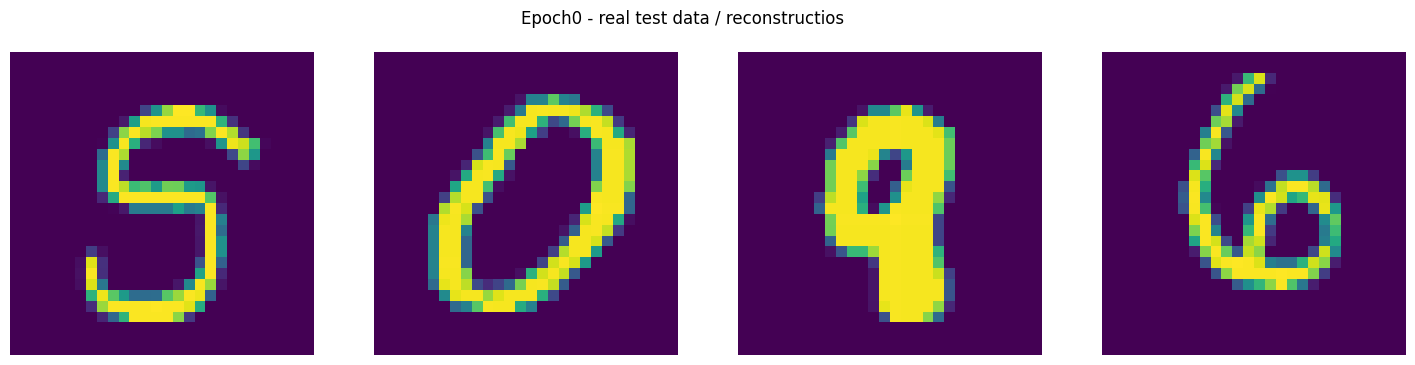

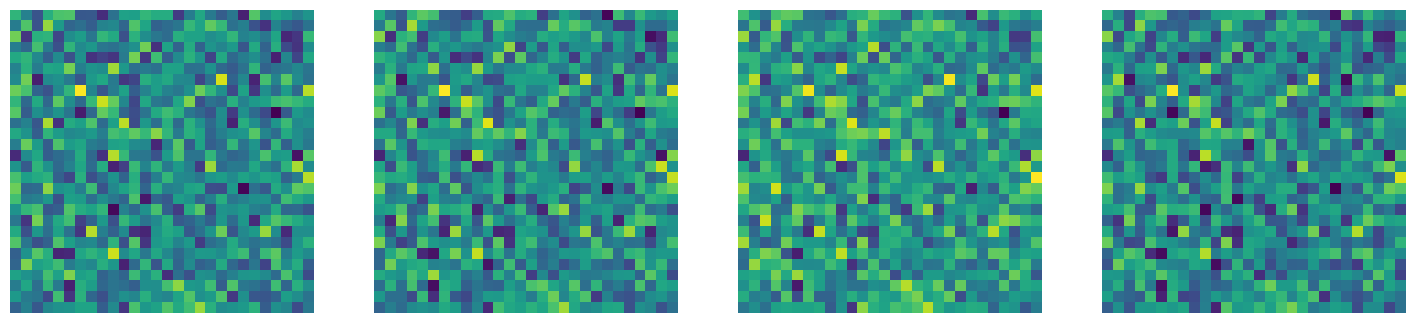

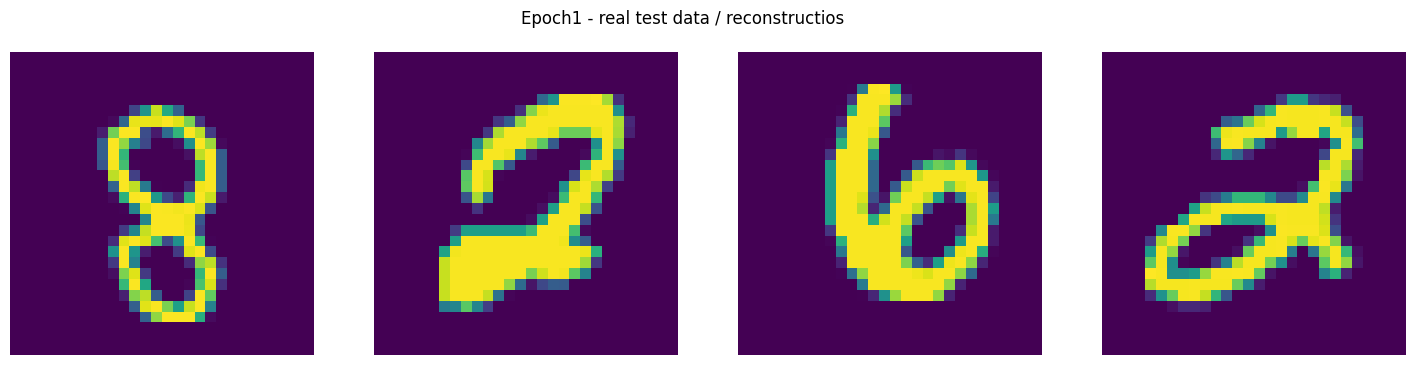

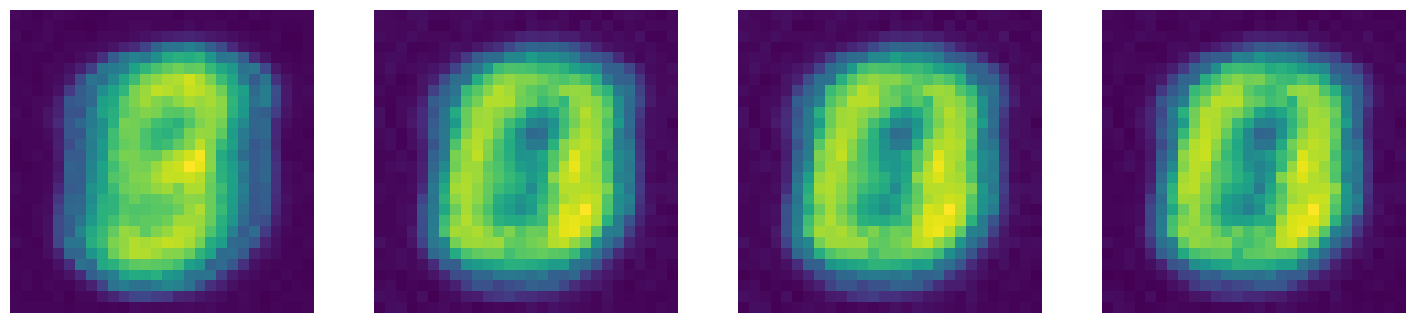

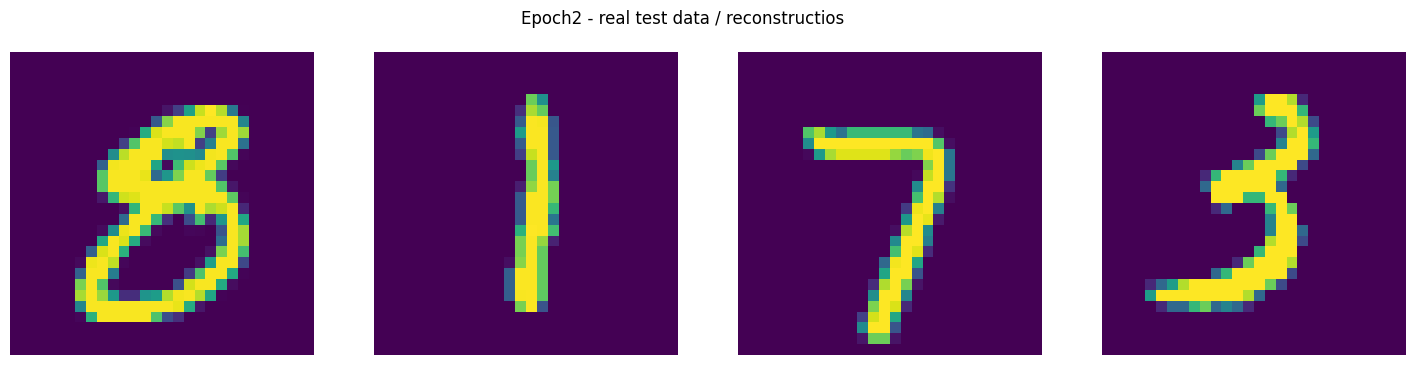

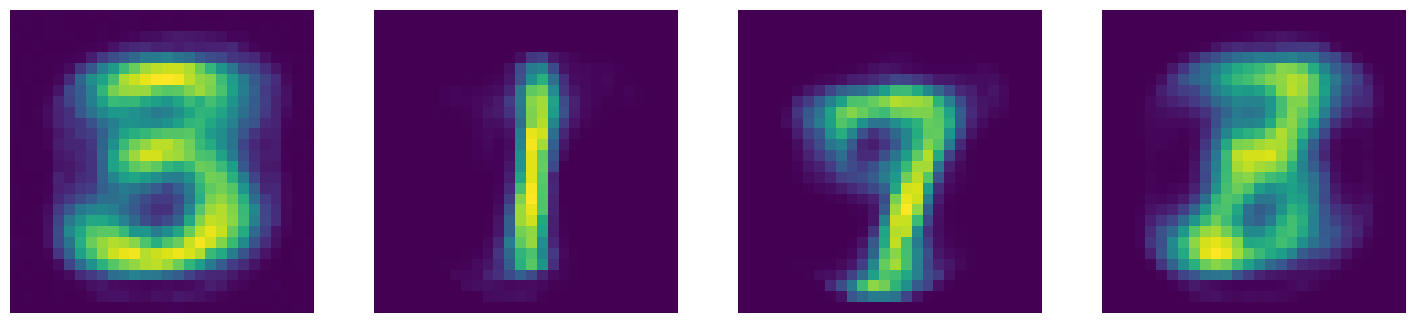

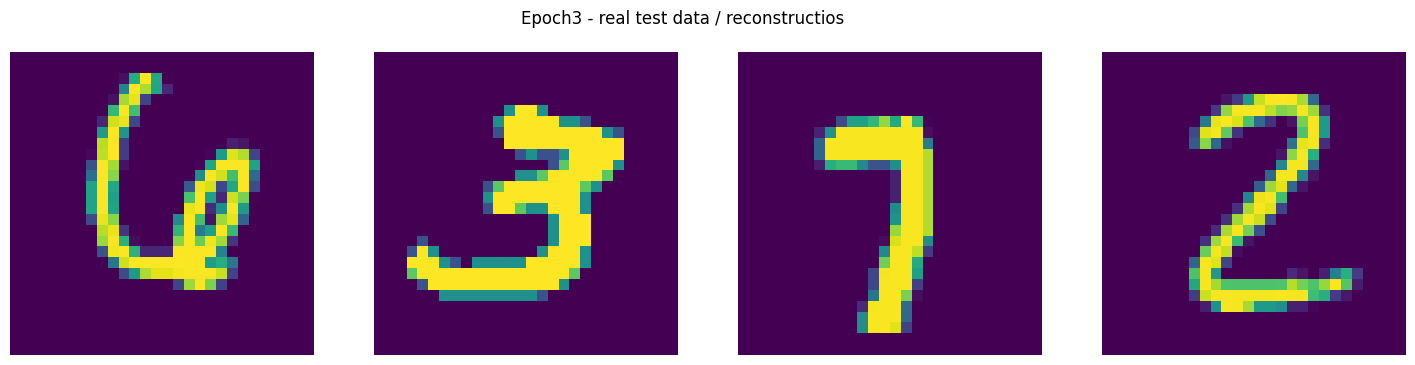

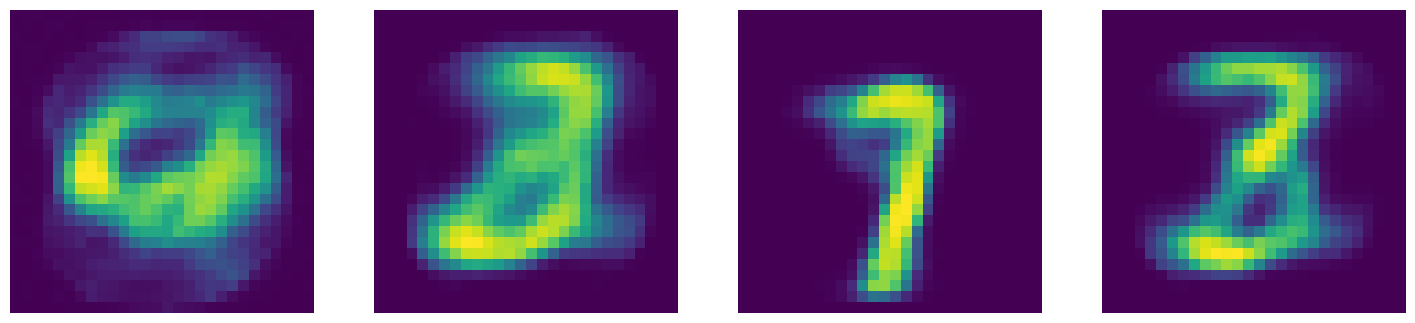

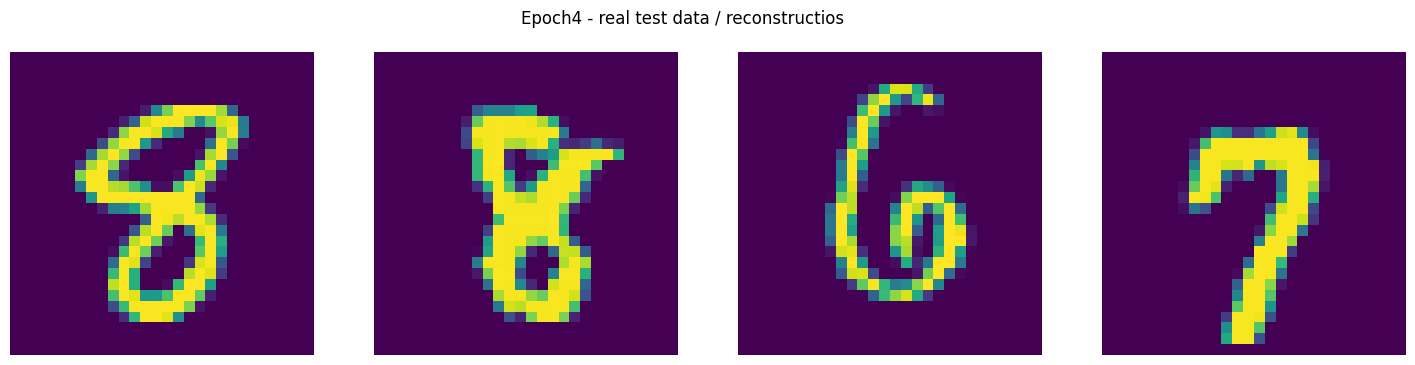

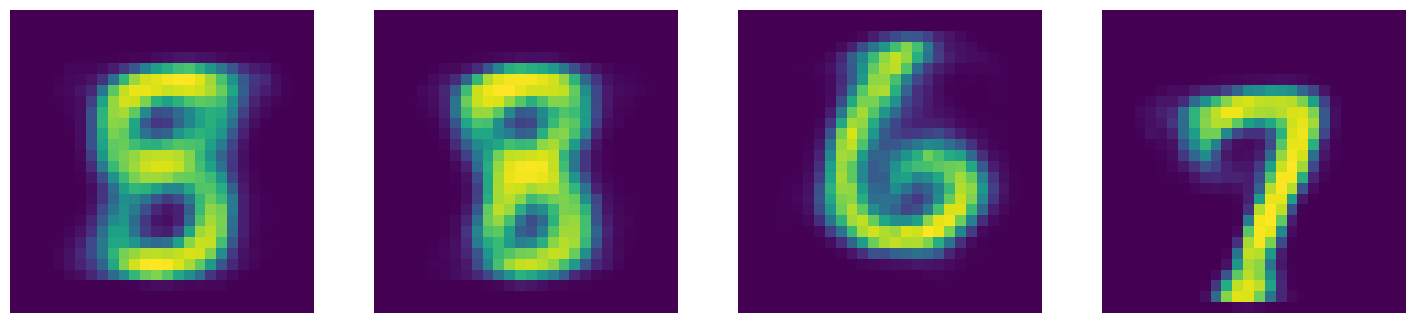

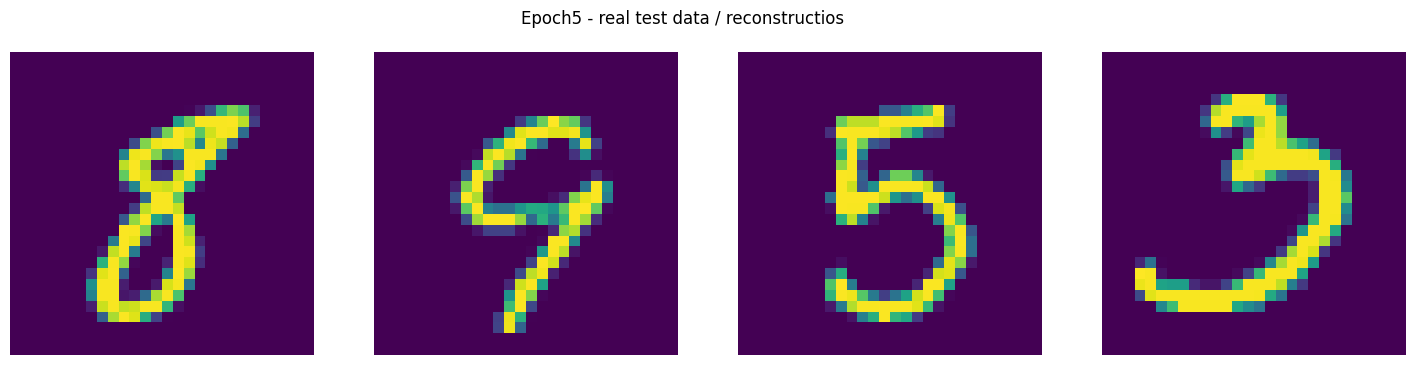

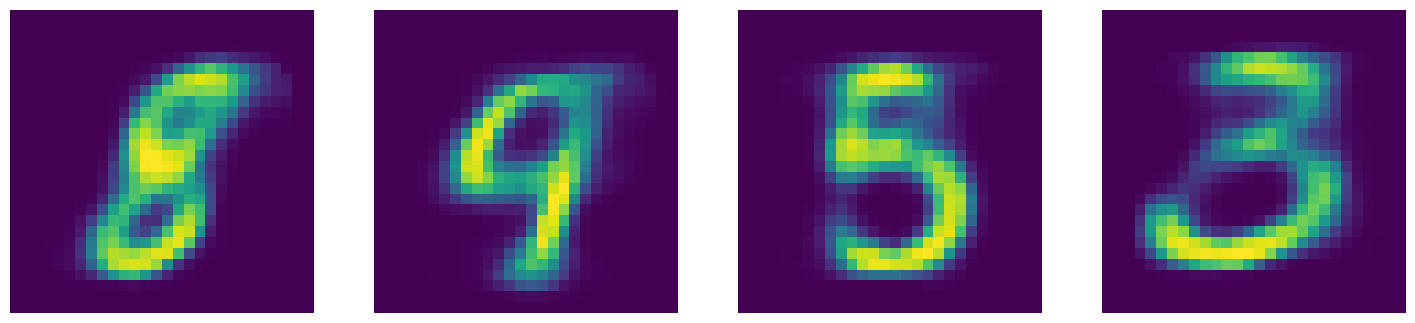

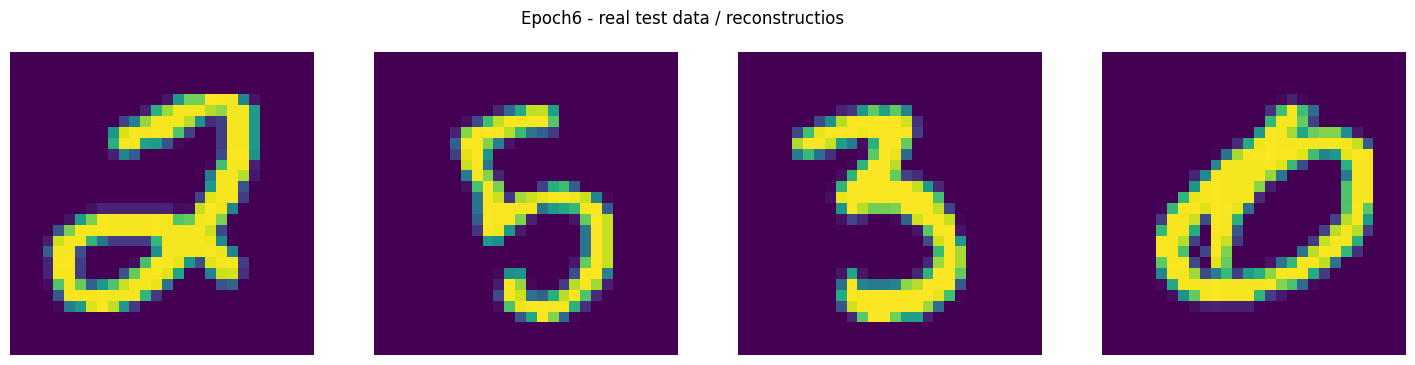

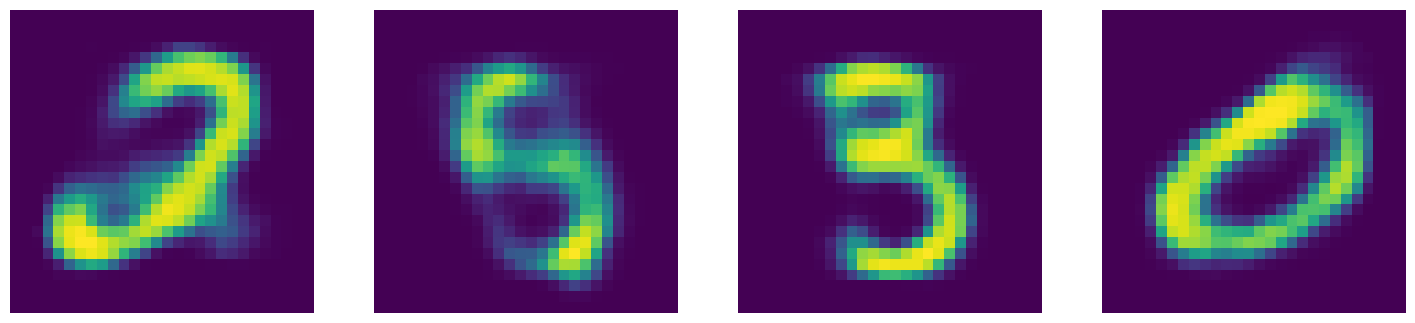

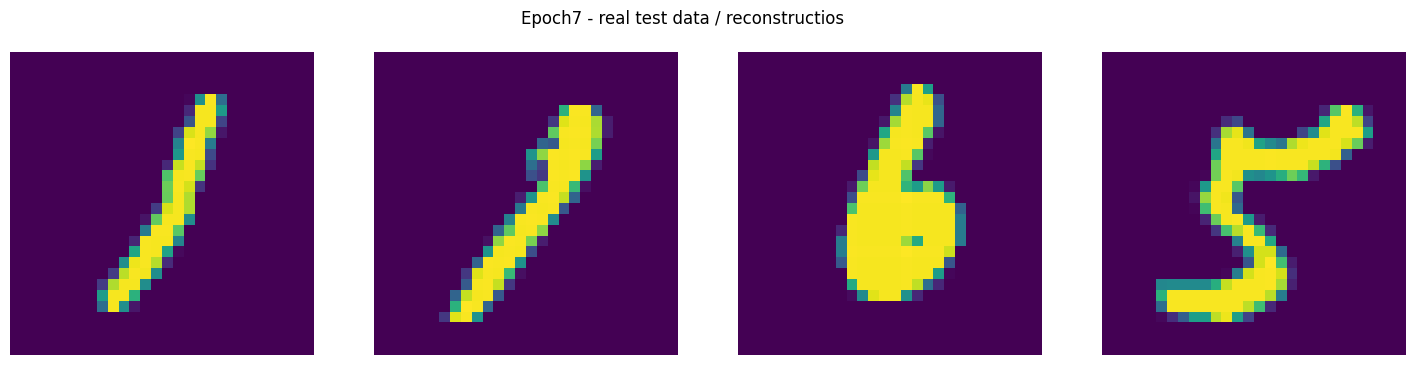

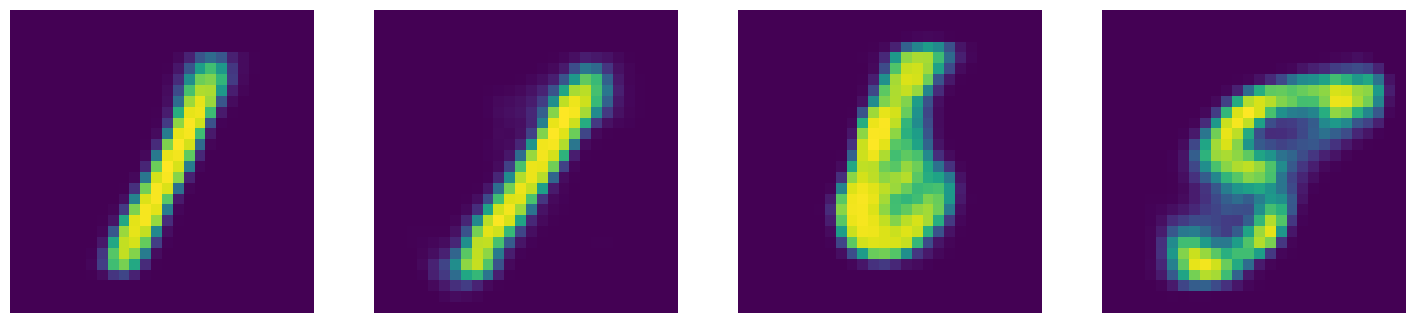

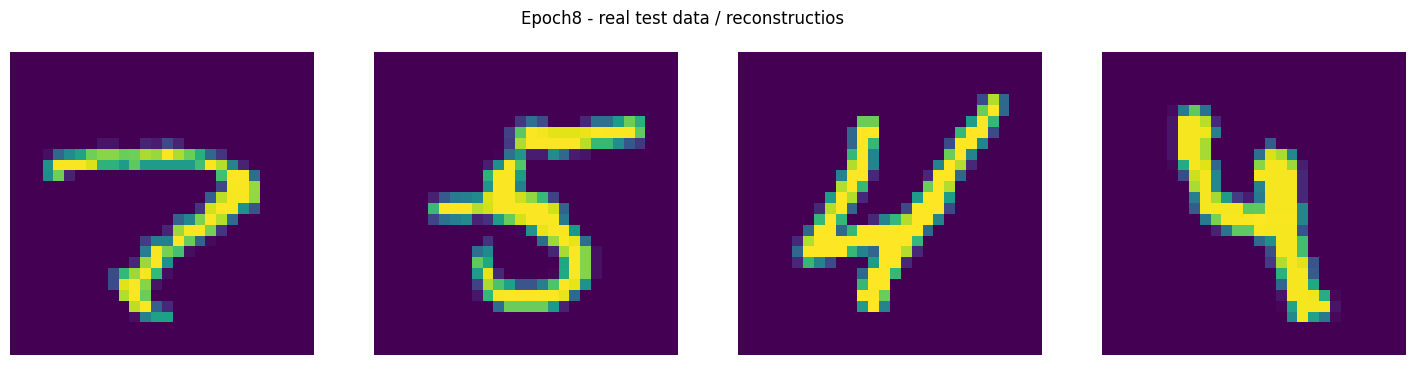

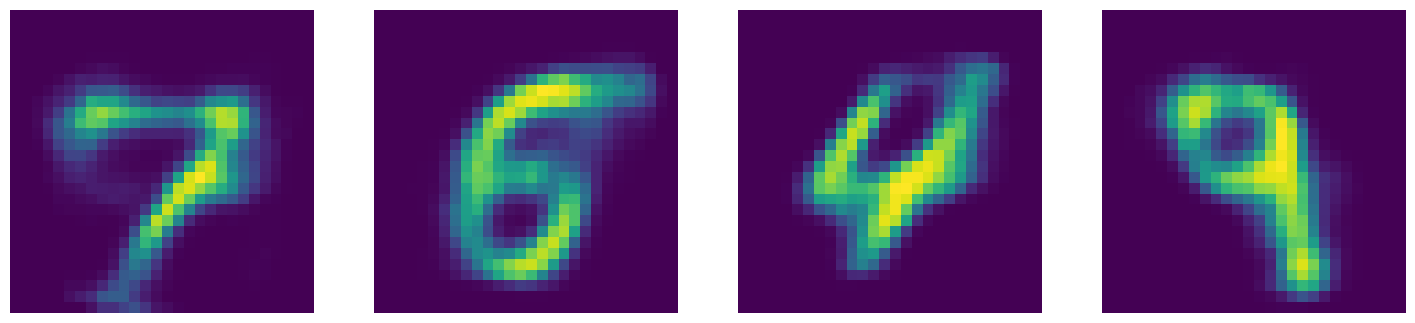

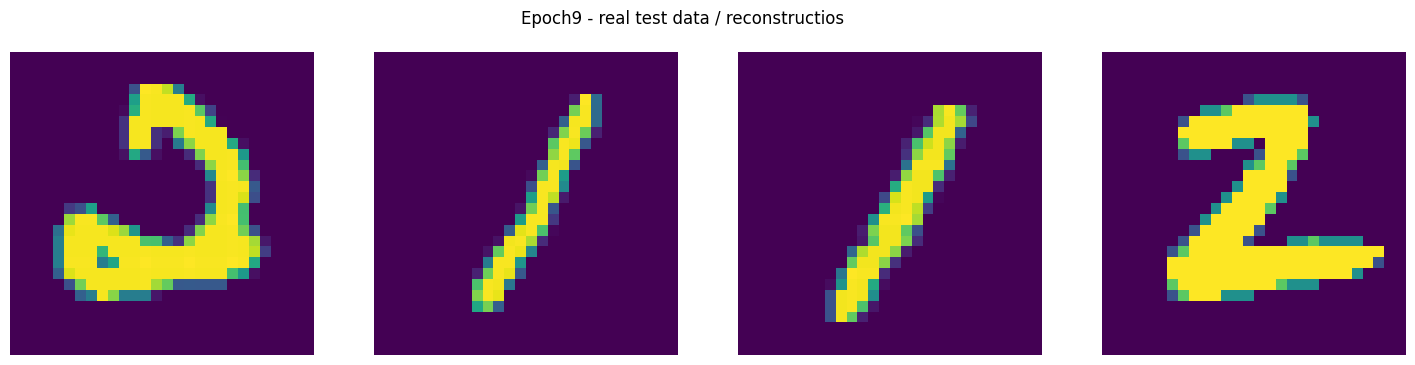

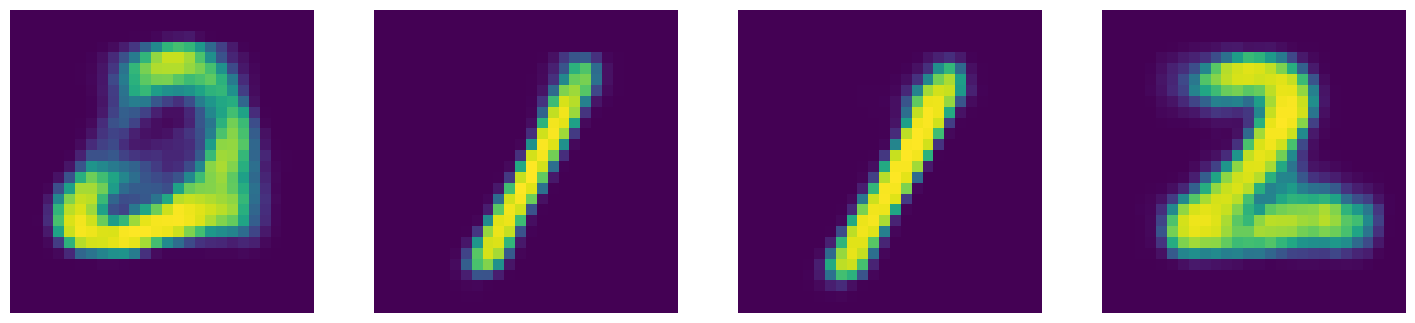

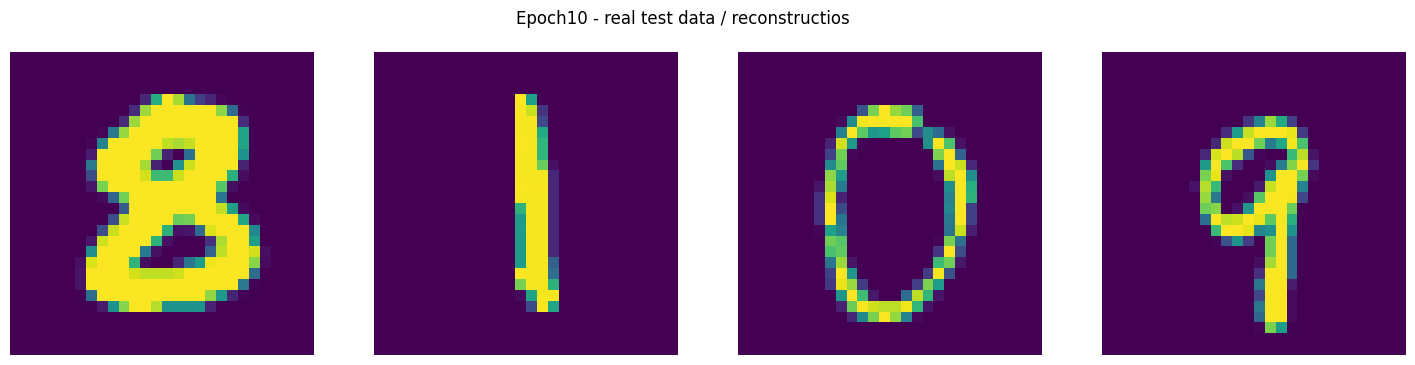

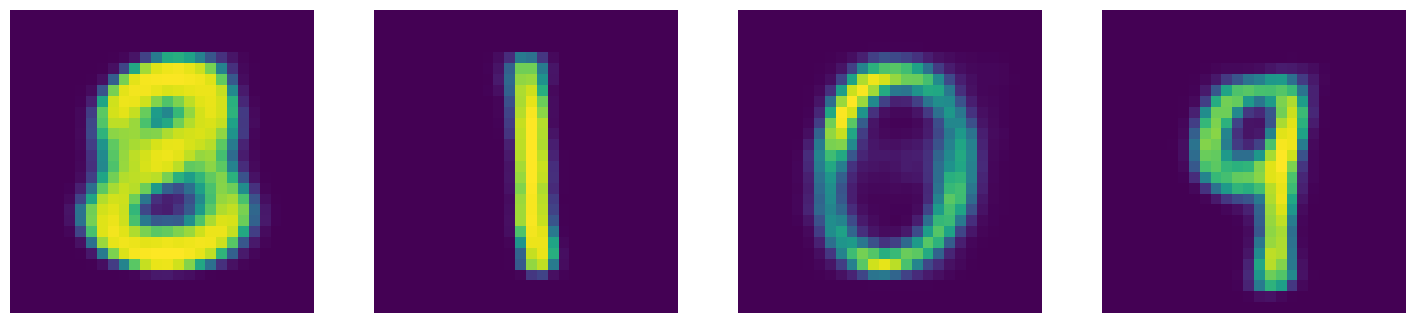

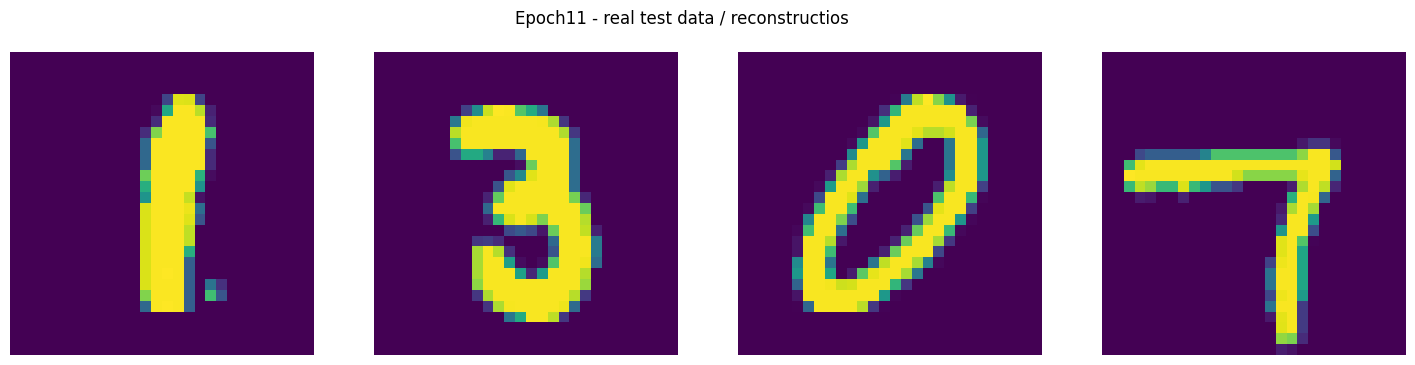

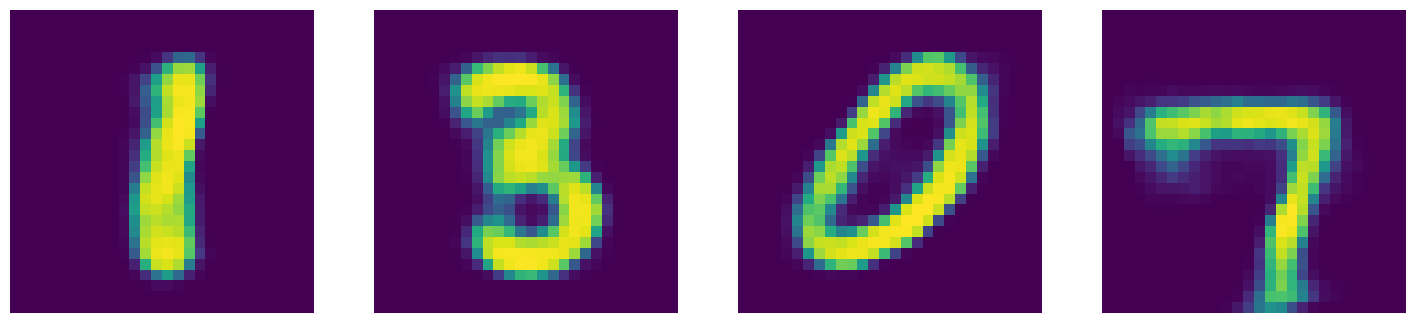

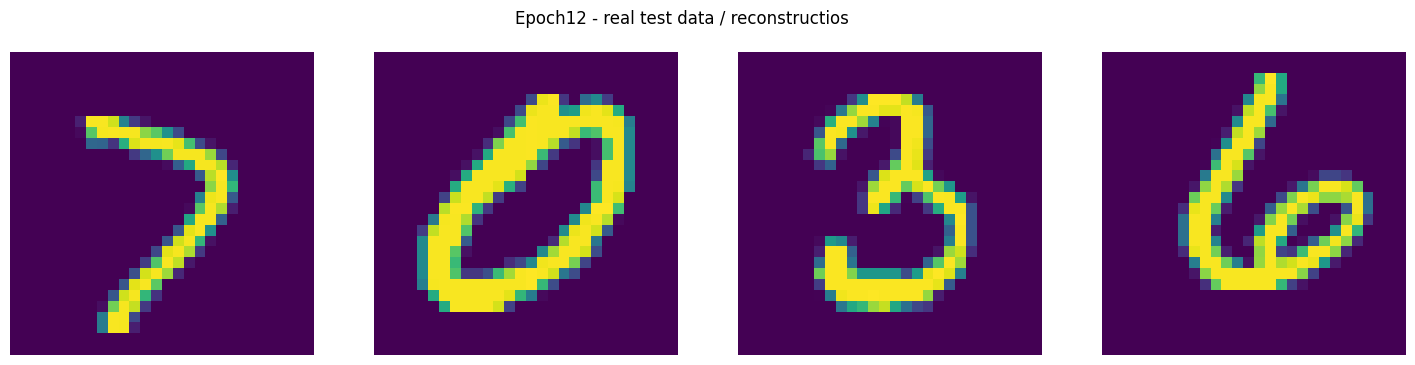

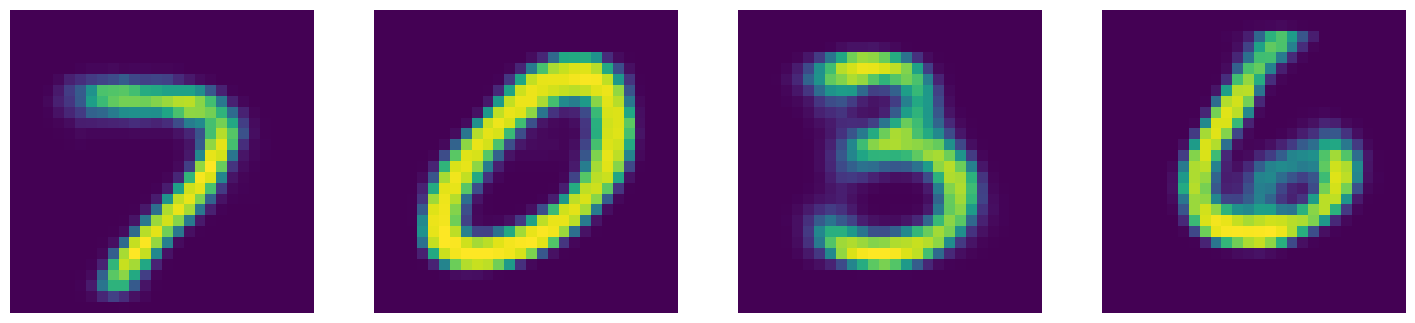

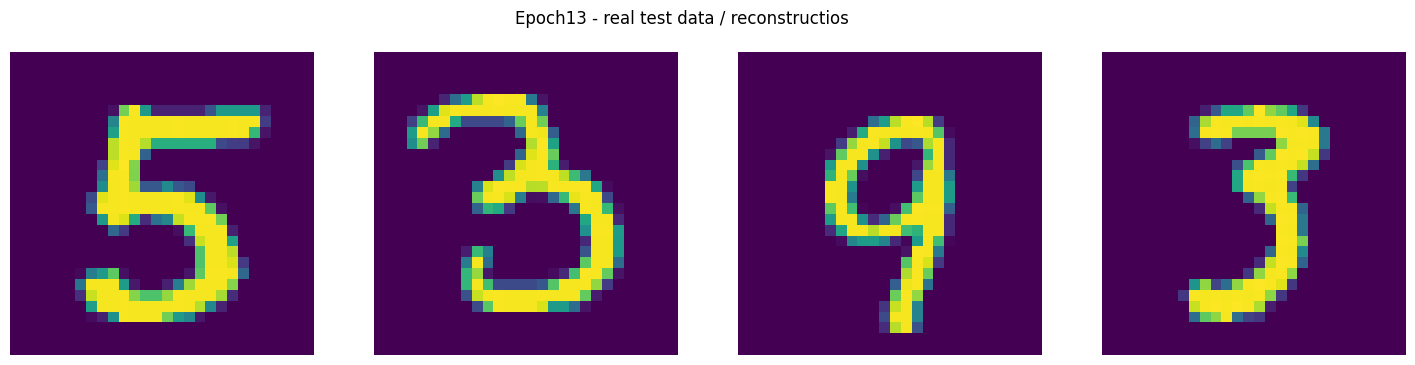

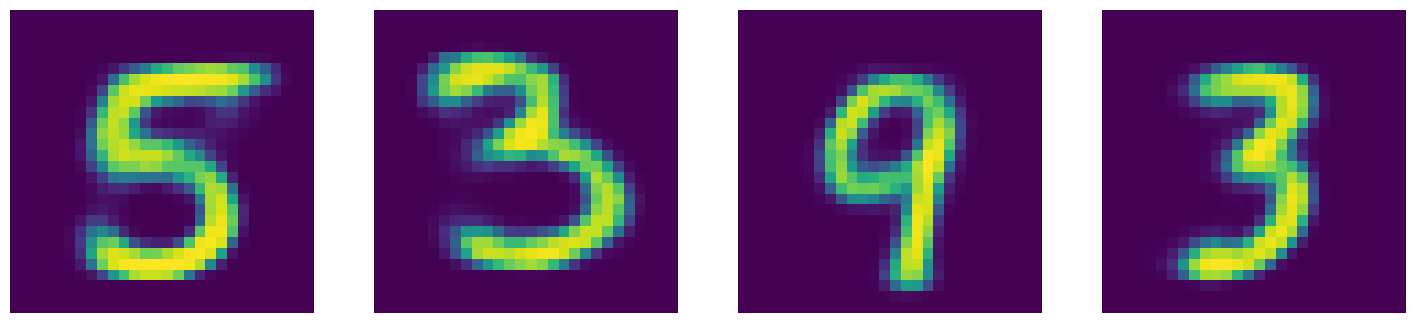

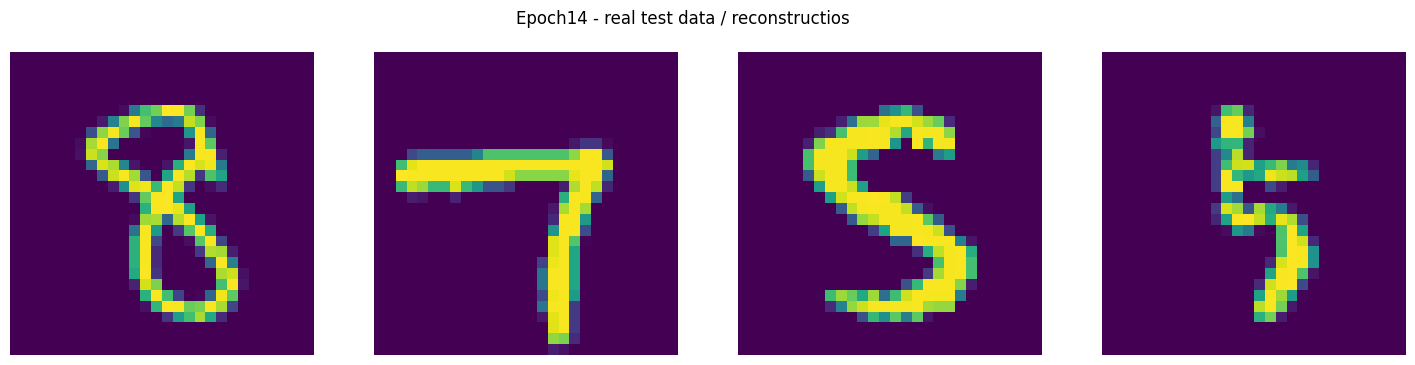

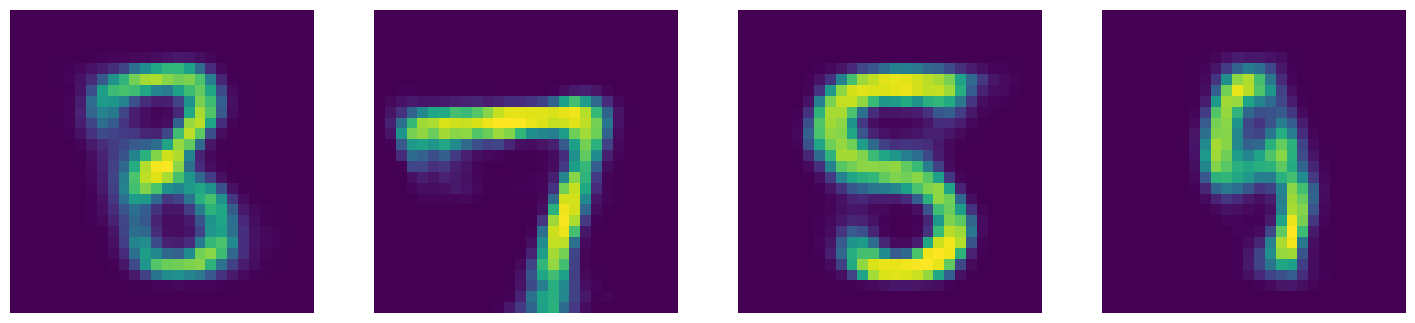

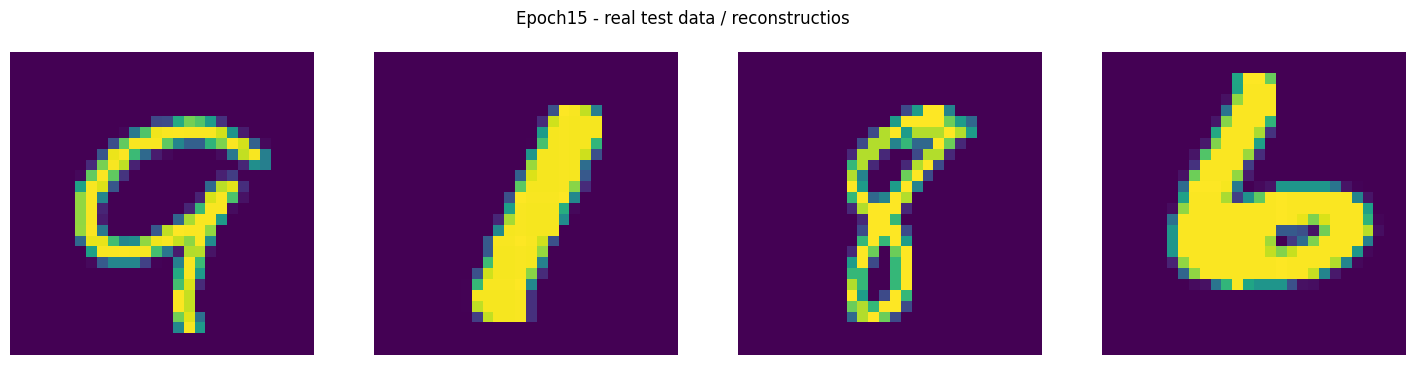

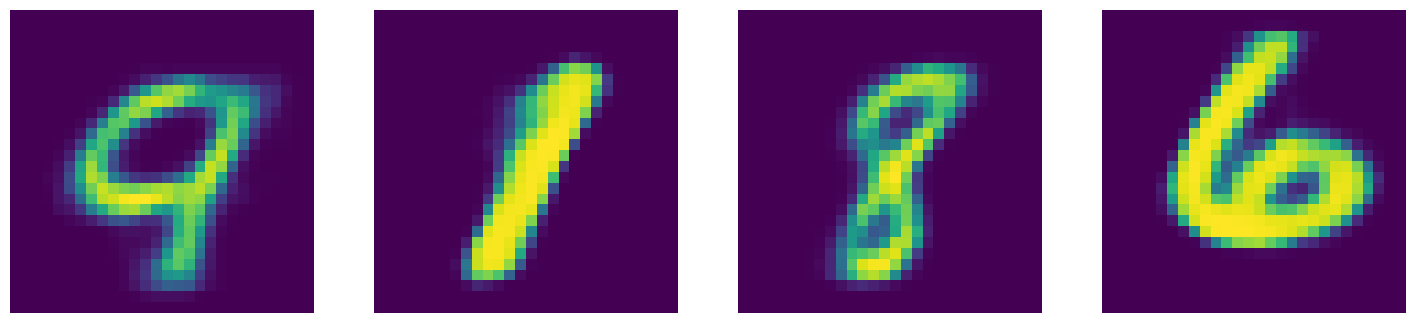

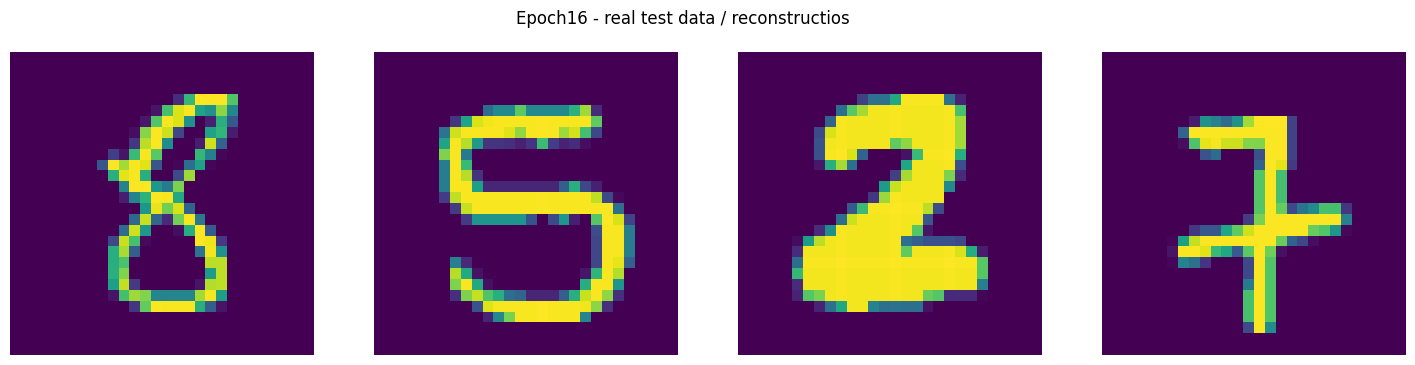

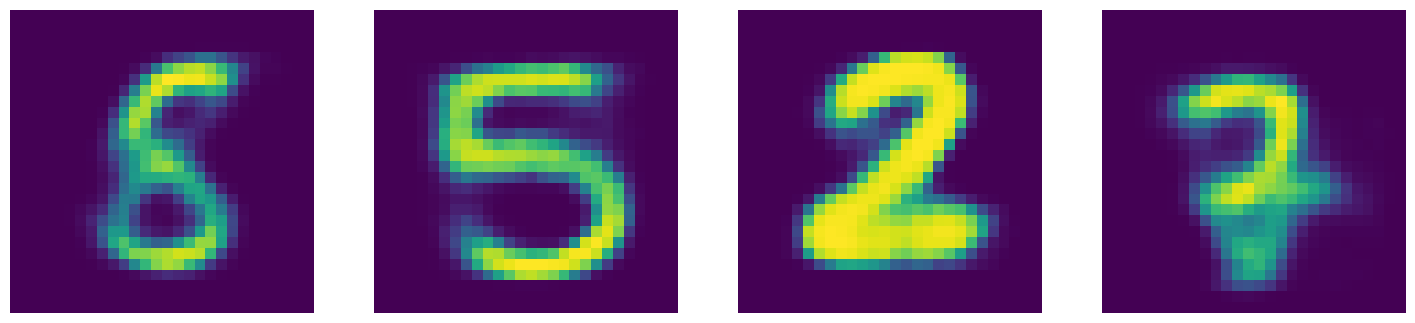

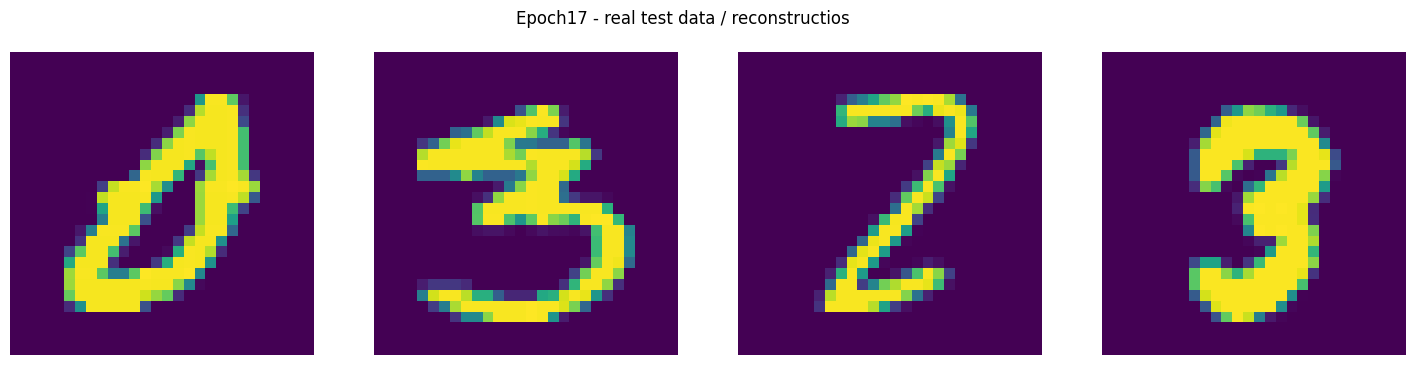

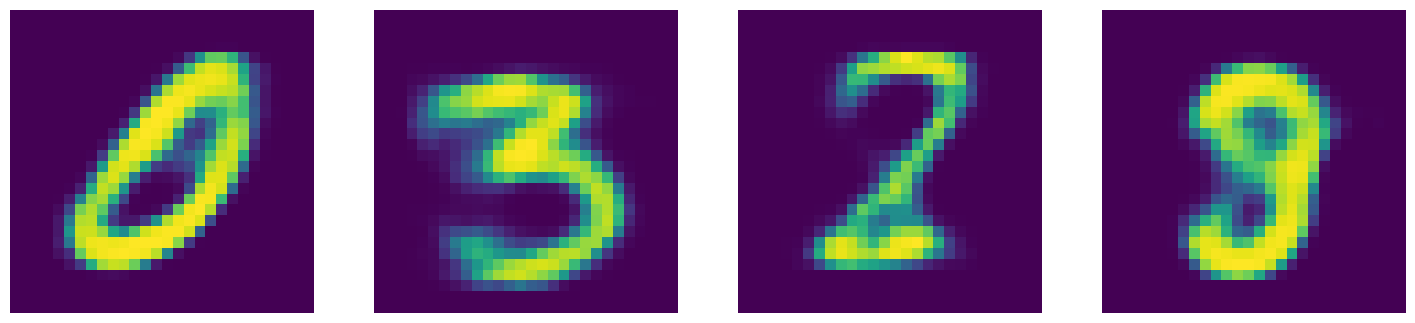

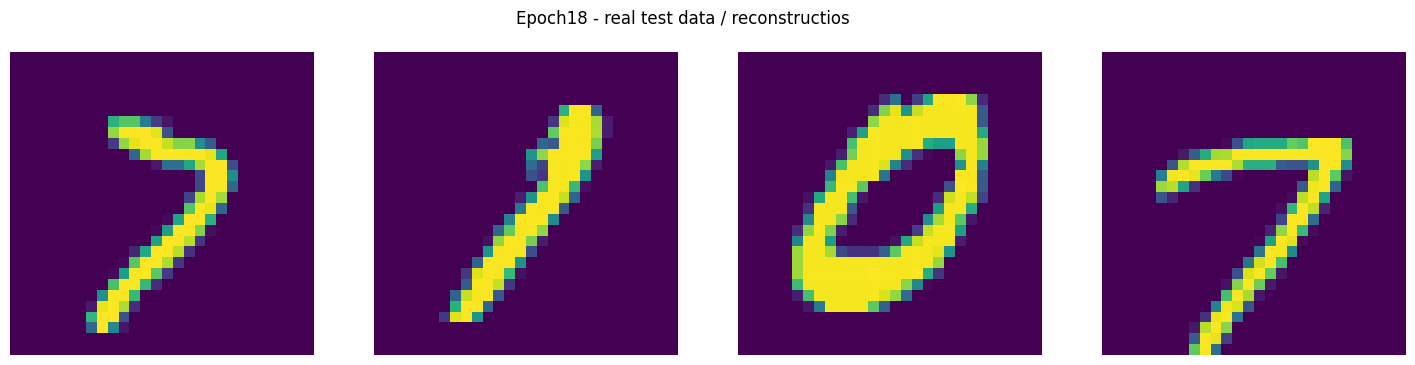

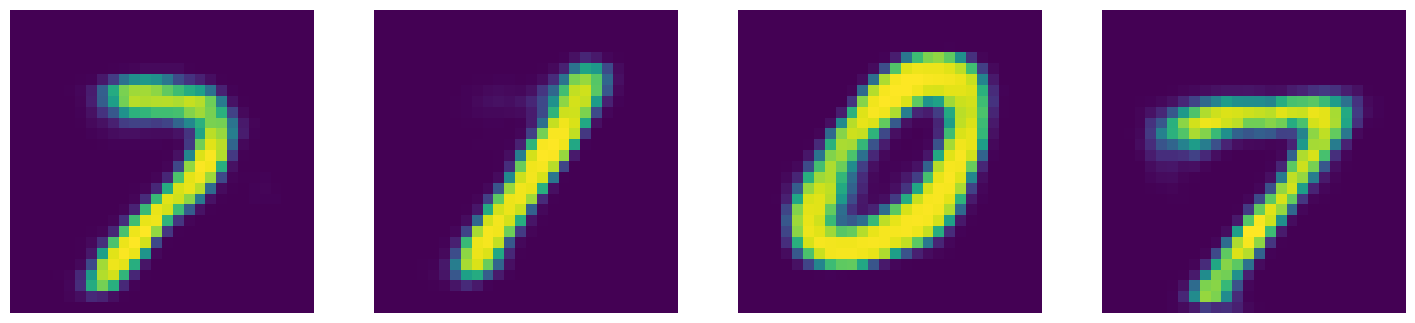

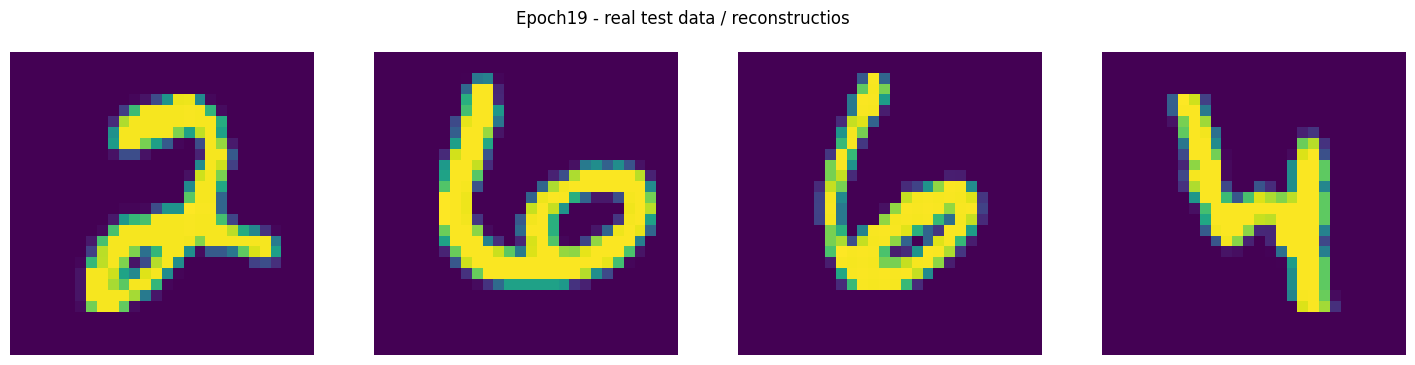

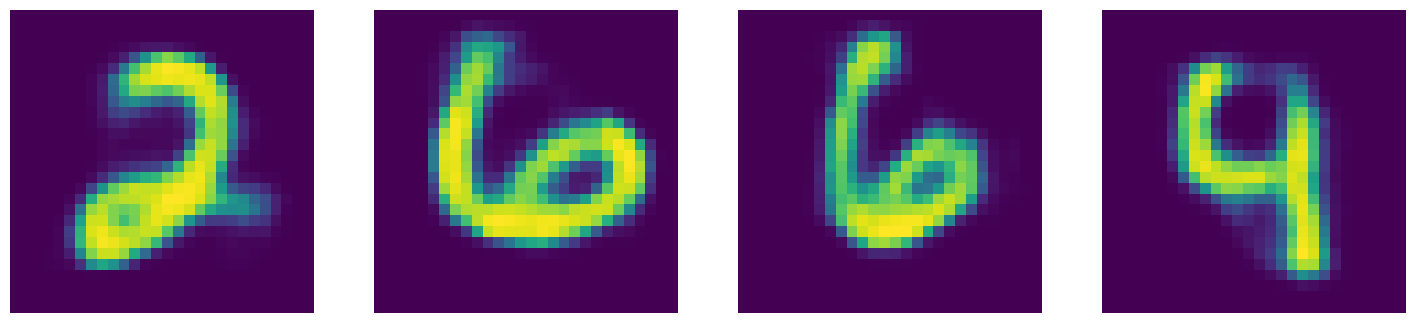

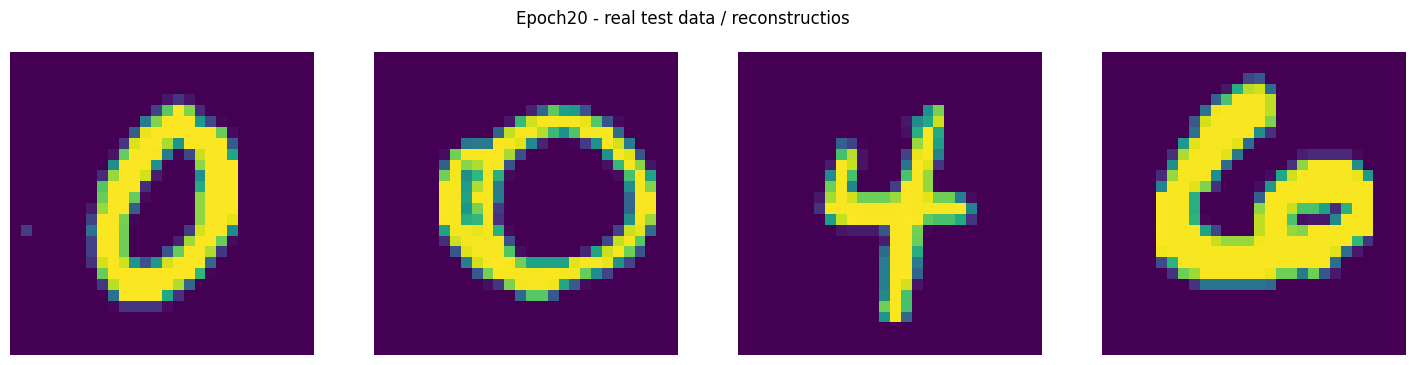

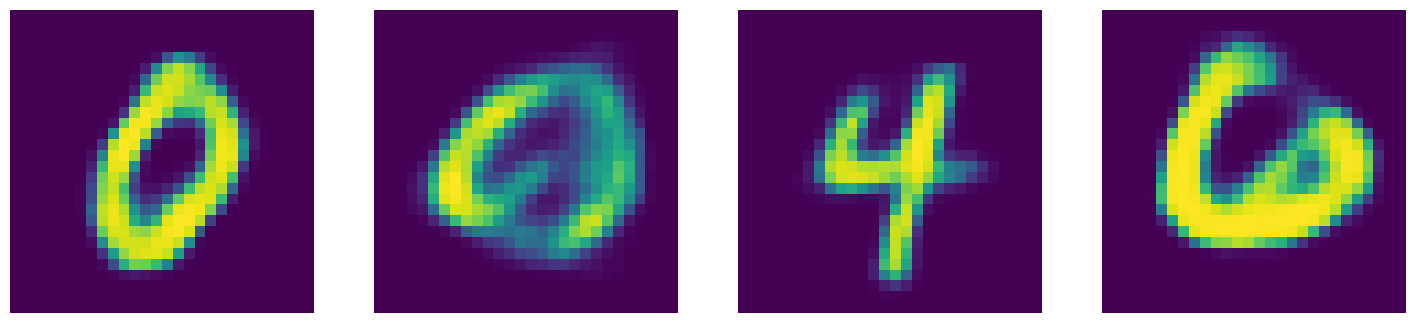

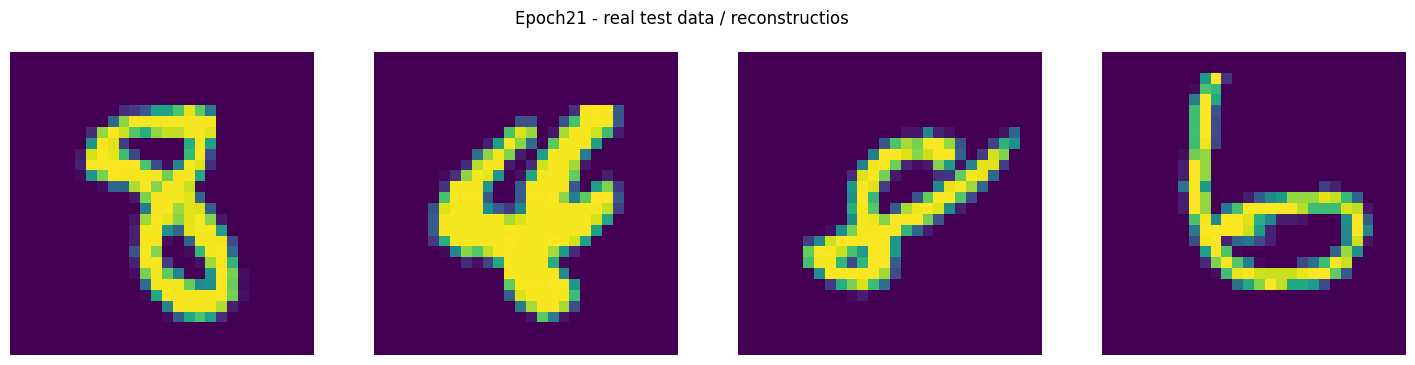

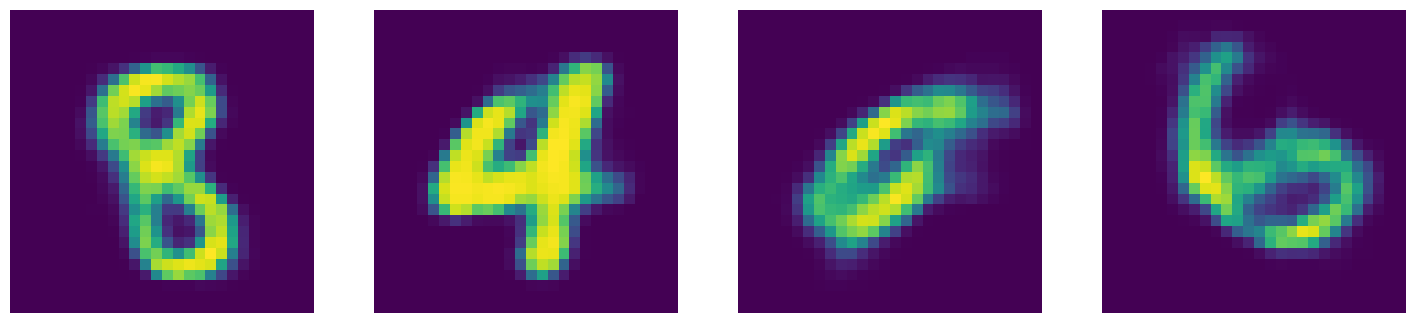

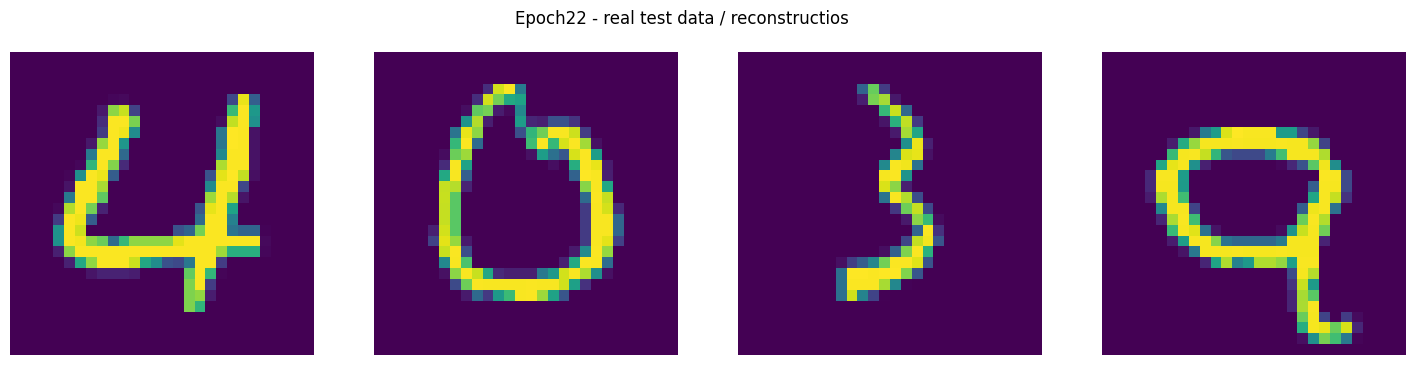

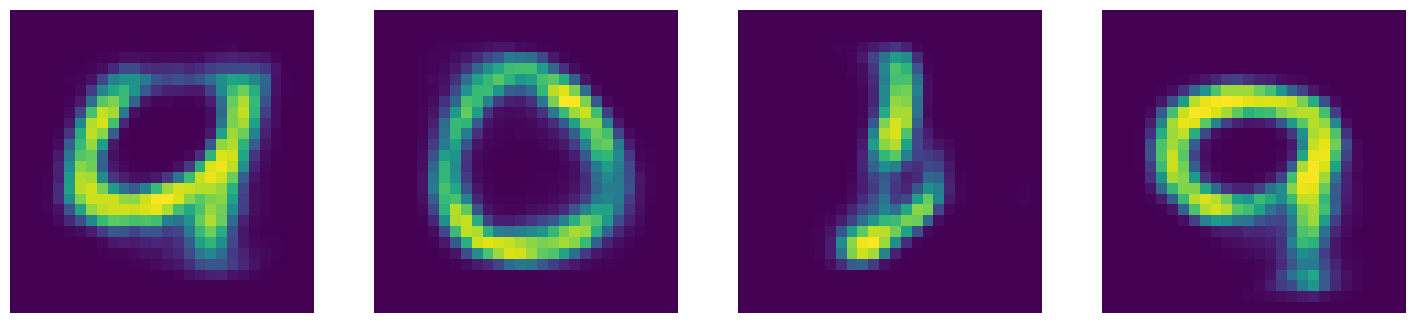

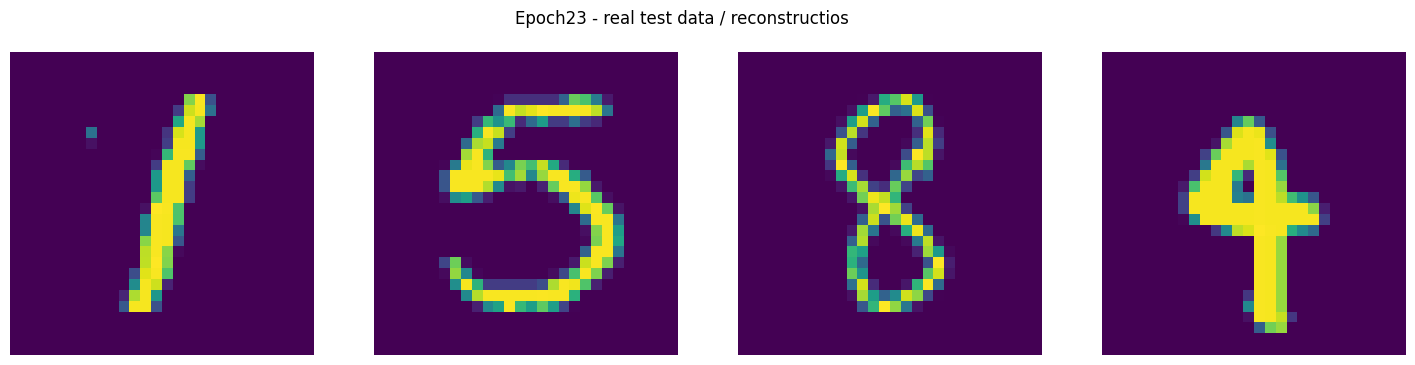

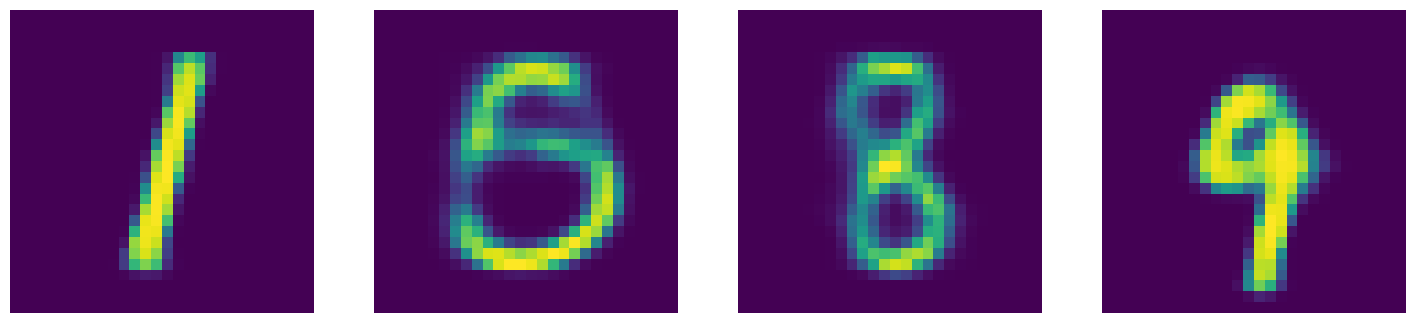

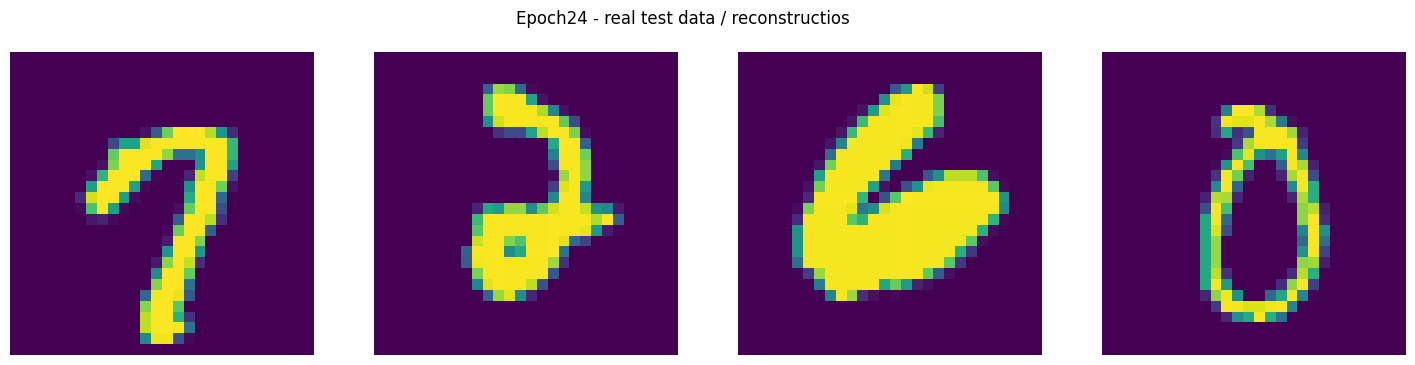

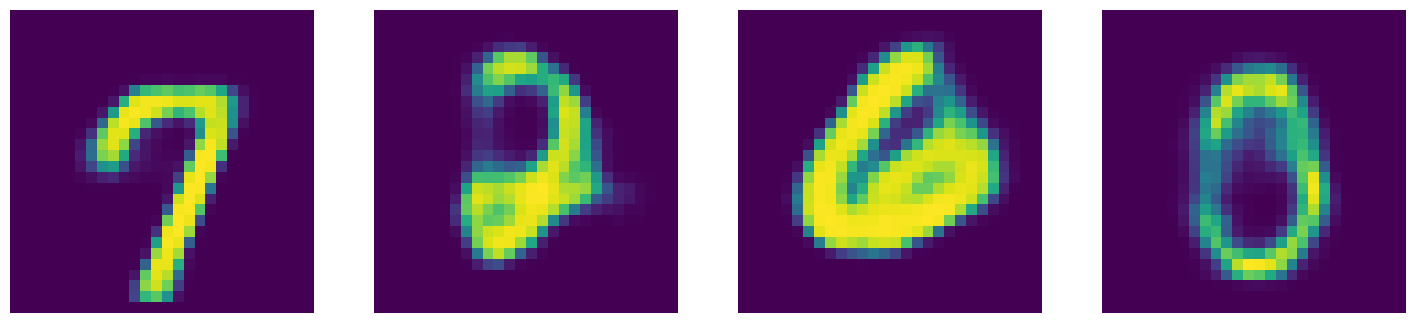

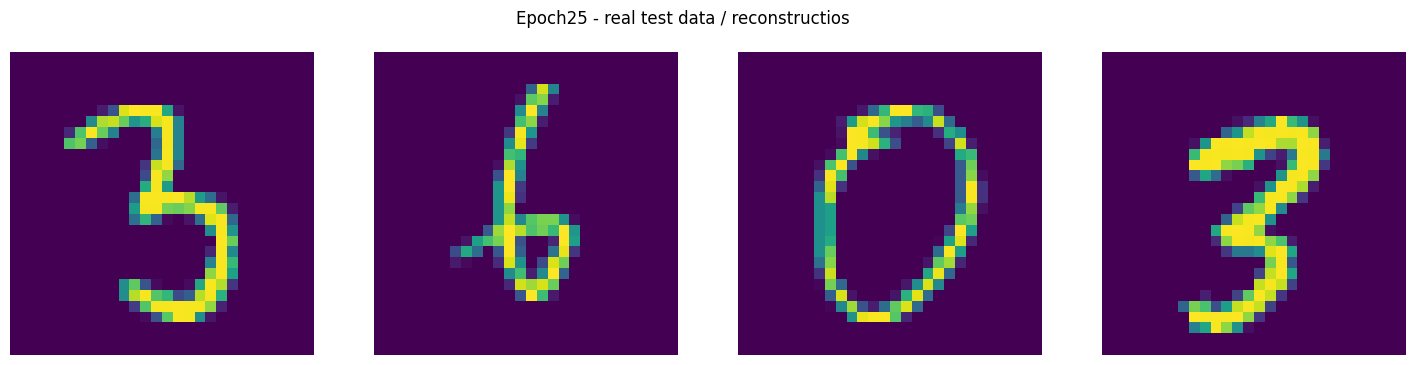

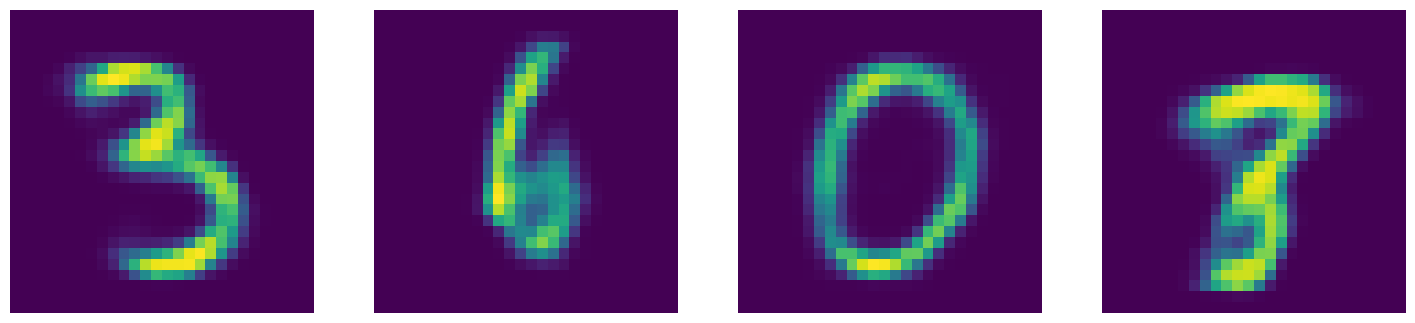

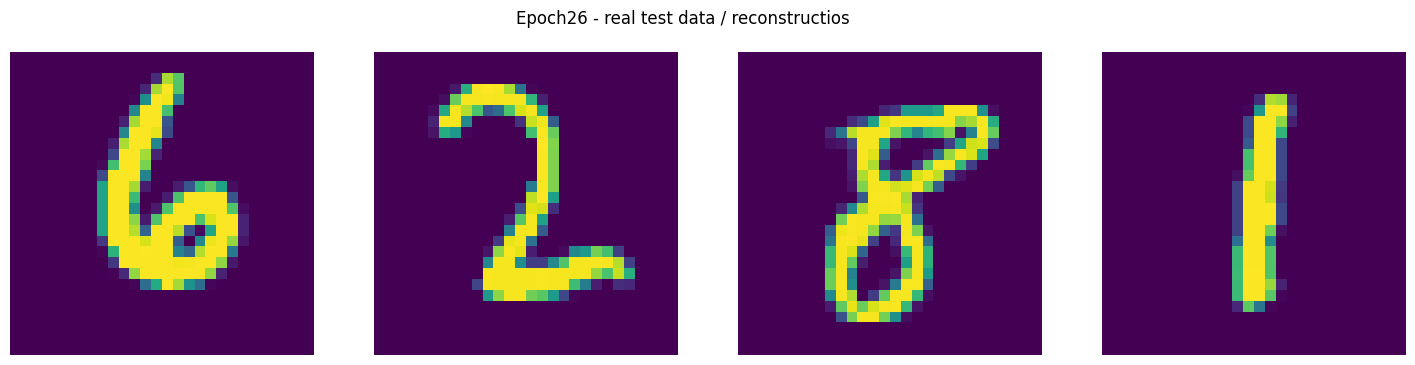

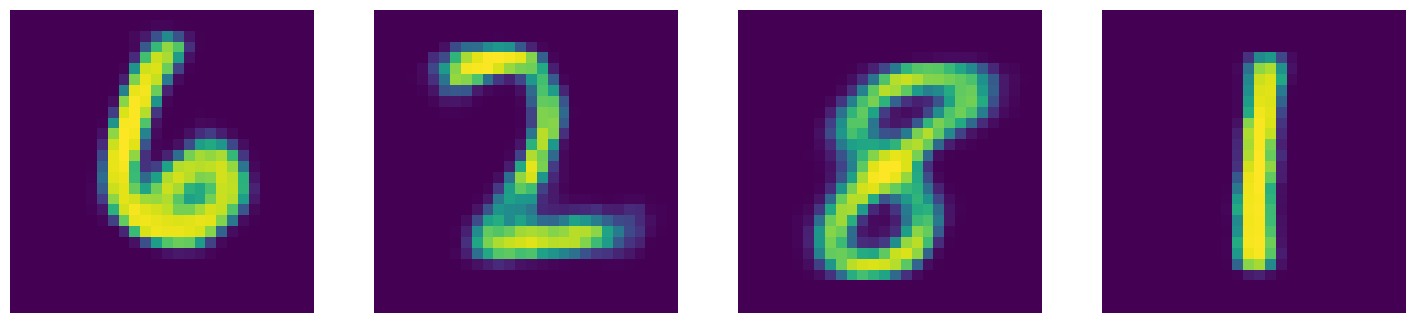

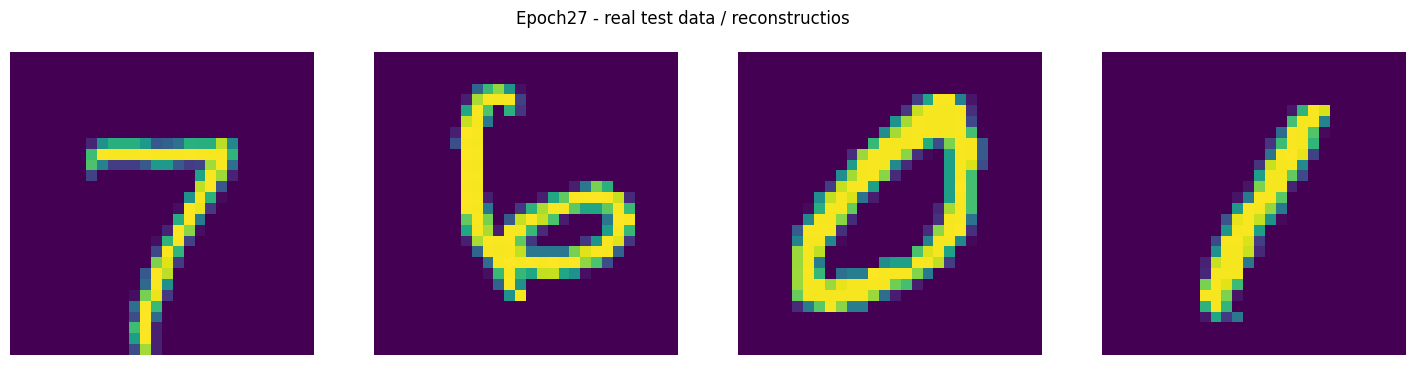

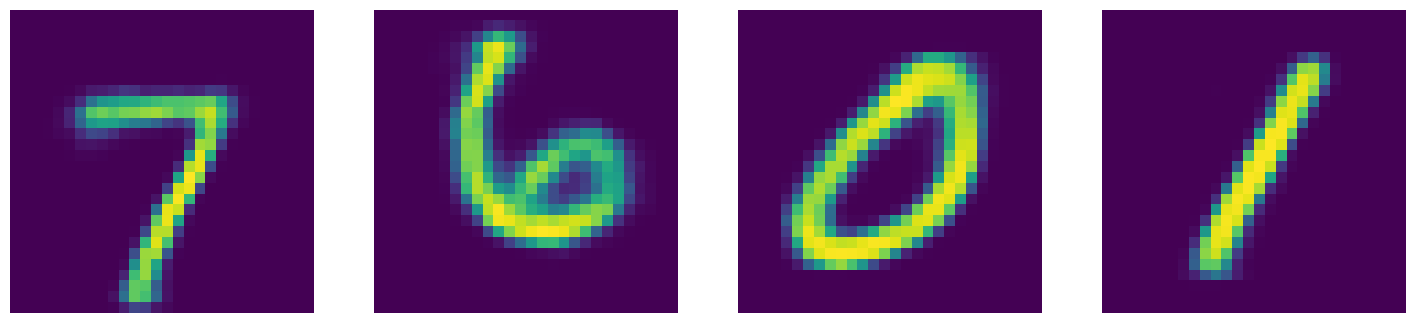

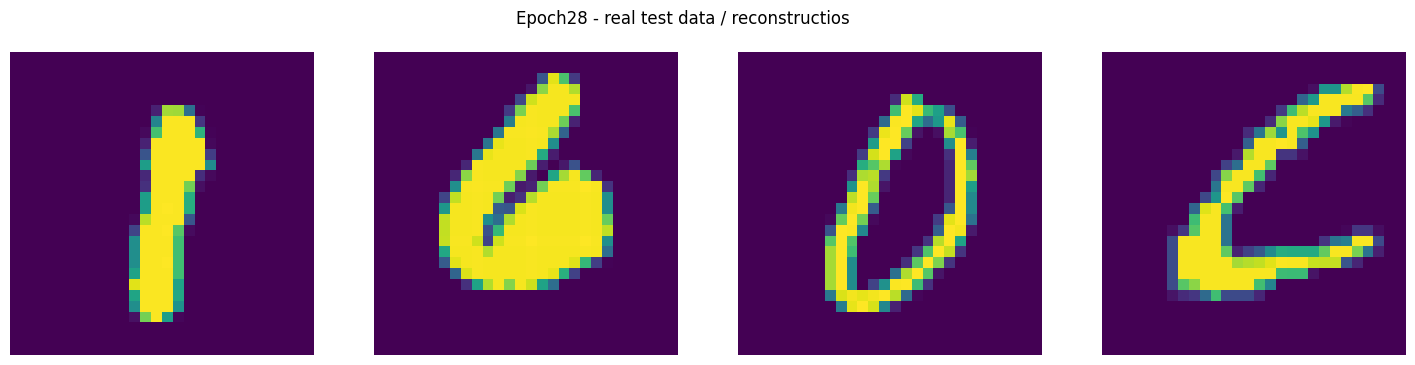

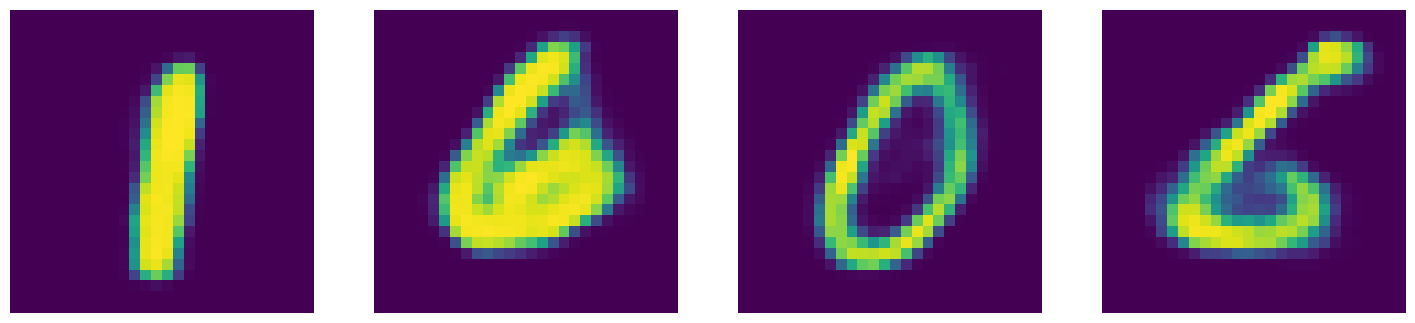

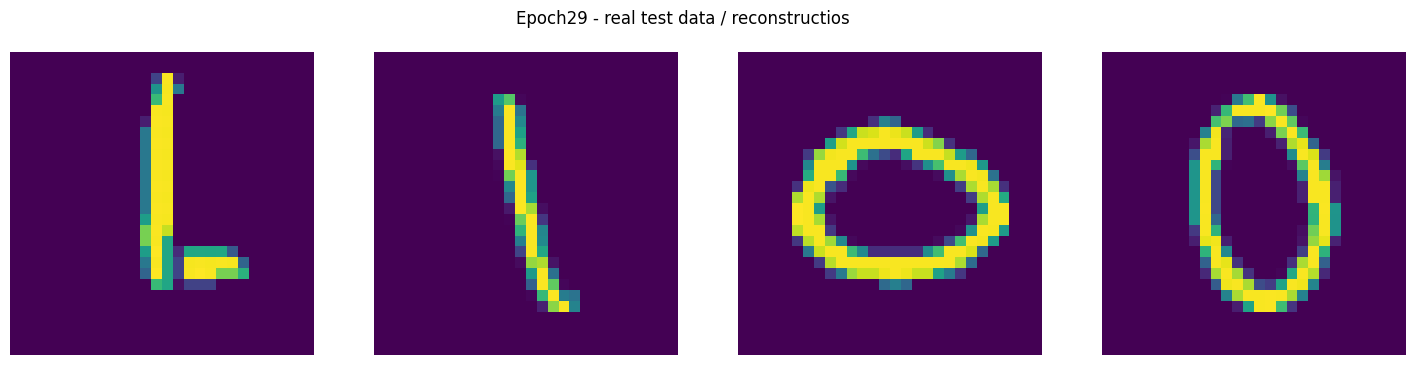

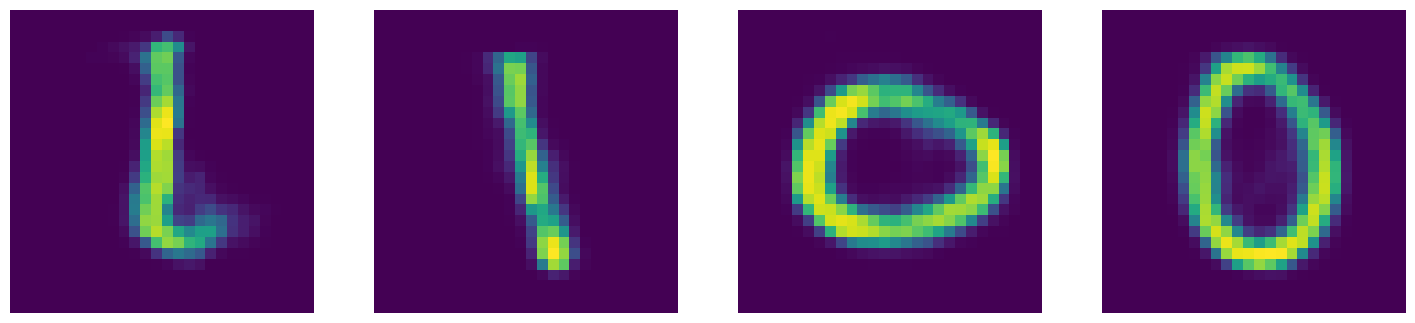

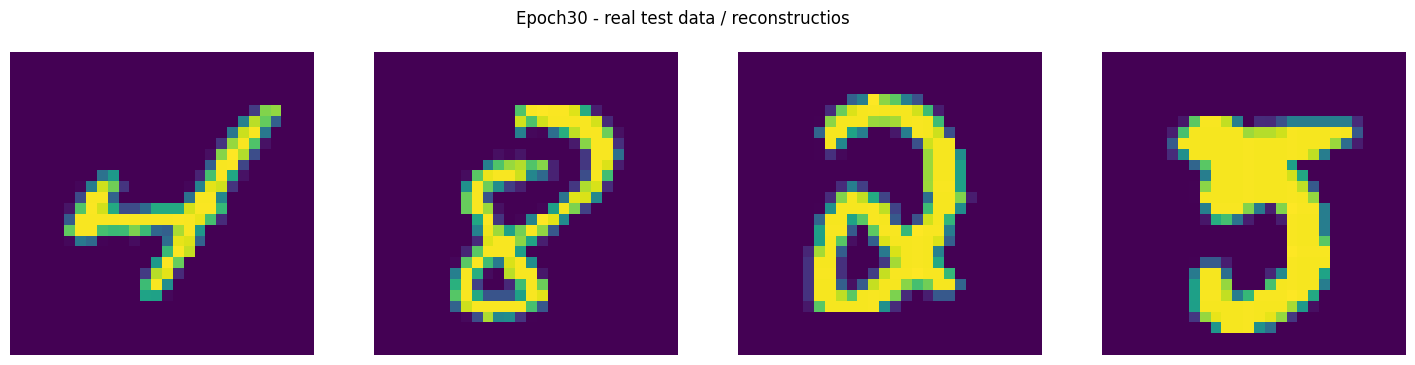

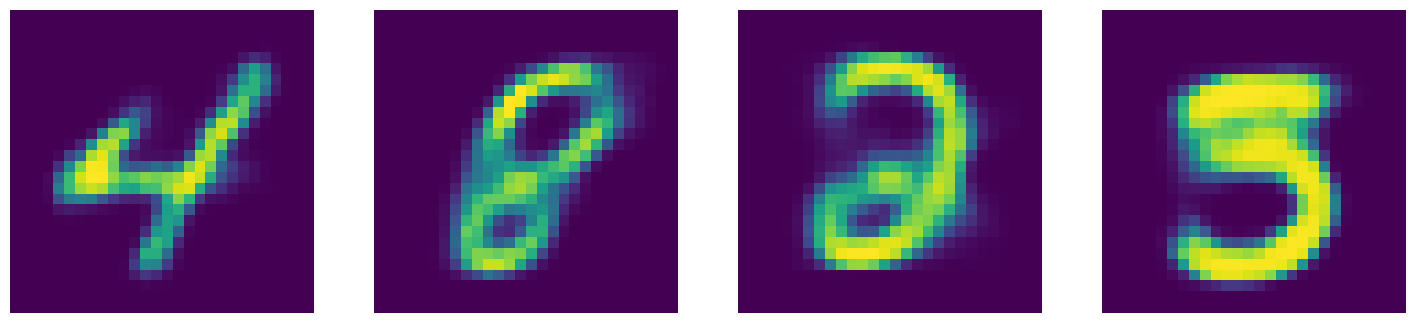

In [9]:
# Training and testing the VAEGAN
epochs = 30
codes = dict(mu=list(), logsigmabase2=list(), x=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for y, _ in train_loader:
            y = y.to(device)
            # ============forward===============================
            ybar, mu, logvar = model(y)
            loss = loss_function(ybar, y, mu, logvar)
            #discriminator_loss = discriminator_criterion(model.discriminate(ybar), torch.ones(y.size(0), 1).to(device))
            real_labels = torch.ones(y.size(0), 1).to(device)
            fake_labels = torch.zeros(y.size(0), 1).to(device)
            real_loss = discriminator_criterion(model.discriminate(y), real_labels)
            fake_loss = discriminator_criterion(model.discriminate(ybar.detach()), fake_labels)
            loss+=real_loss+fake_loss
            train_loss += loss.item()
            # ============backward===============================
            optimizer.zero_grad()
            discriminator_optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            discriminator_optimizer.step()
        # ===============log=====================================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader)}')
    # Testing
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for y, x in test_loader:
            y = y.to(device)
            # ================forward===================================
            ybar, mu, logvar = model(y)
            test_loss += loss_function(ybar, y, mu, logvar).item()
            # =================log======================================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(x.detach())
    # =================log======================================
    codes['mu'].append(torch.cat(means))
    codes['logsigmabase2'].append(torch.cat(logvars))
    codes['x'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss: .4f}')
    display_images(y, ybar, 1, f'Epoch{epoch}')

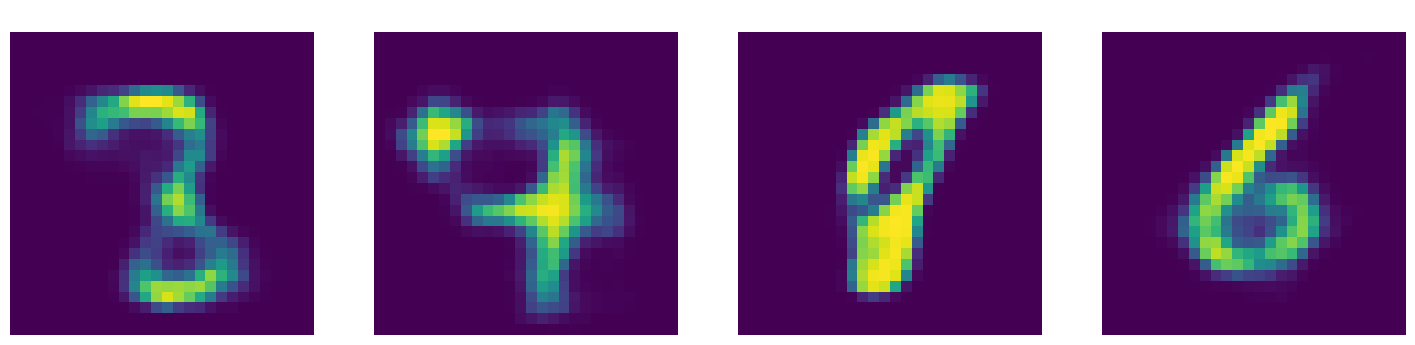

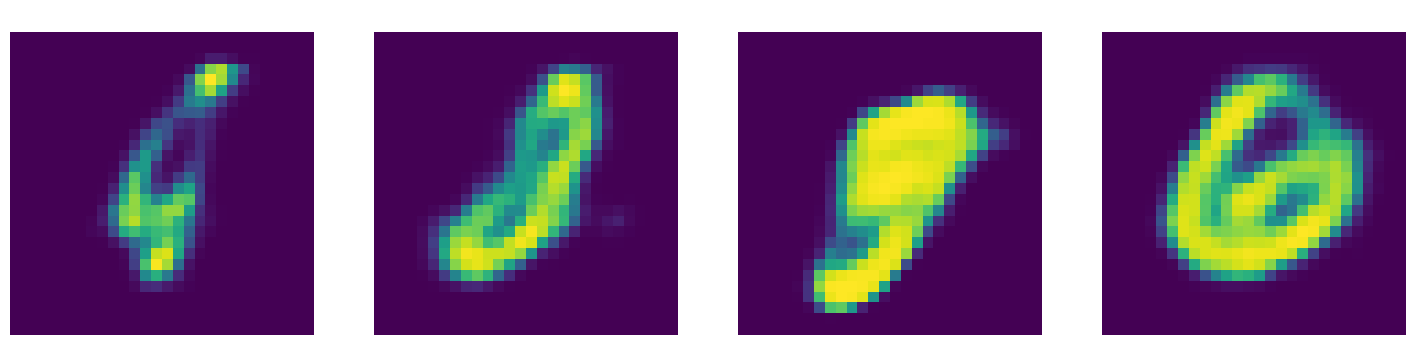

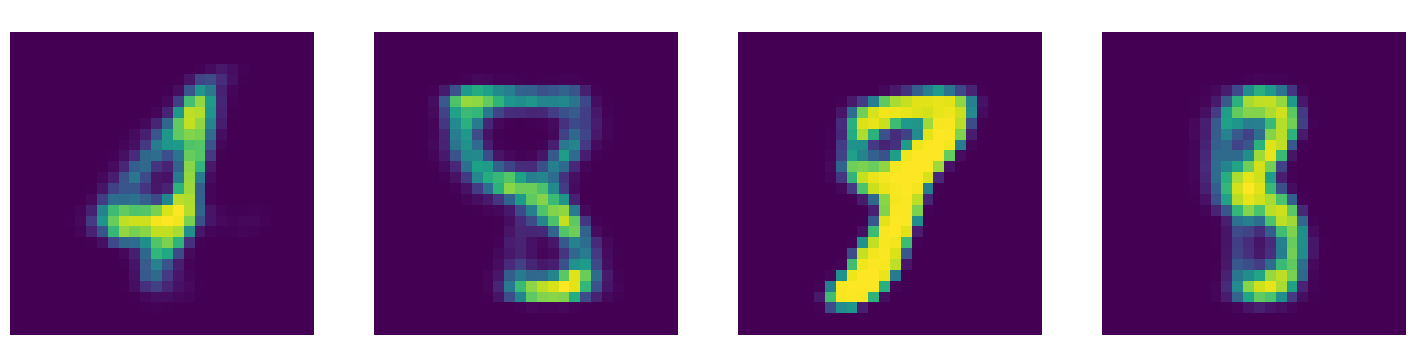

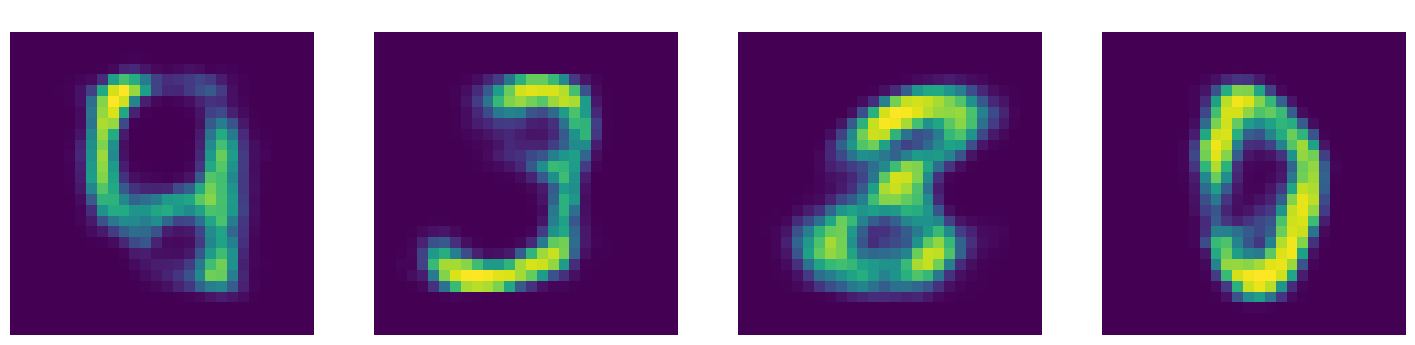

In [10]:
# Generating a few samples
N=16
z=torch.randn((N,d)).to(device)
sample=model.decoder(z)
display_images(None, sample, N//4, count=True)

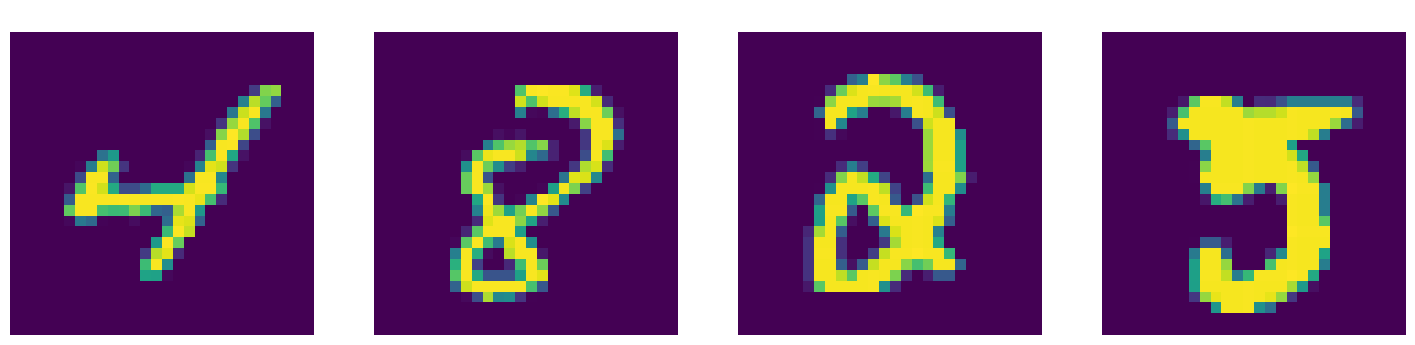

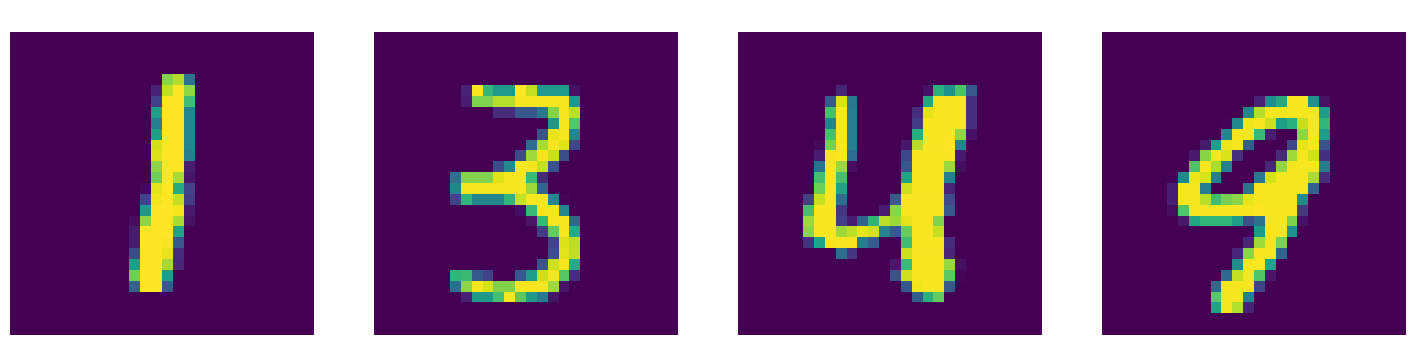

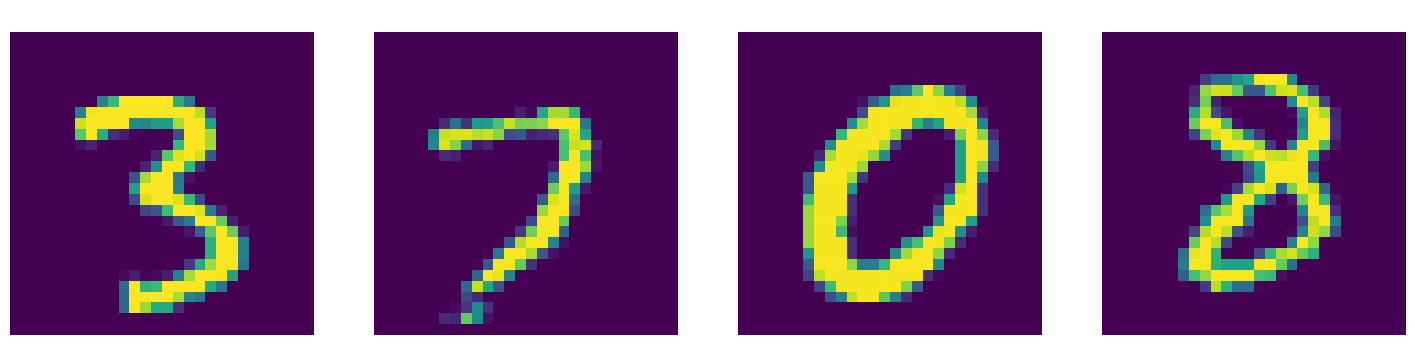

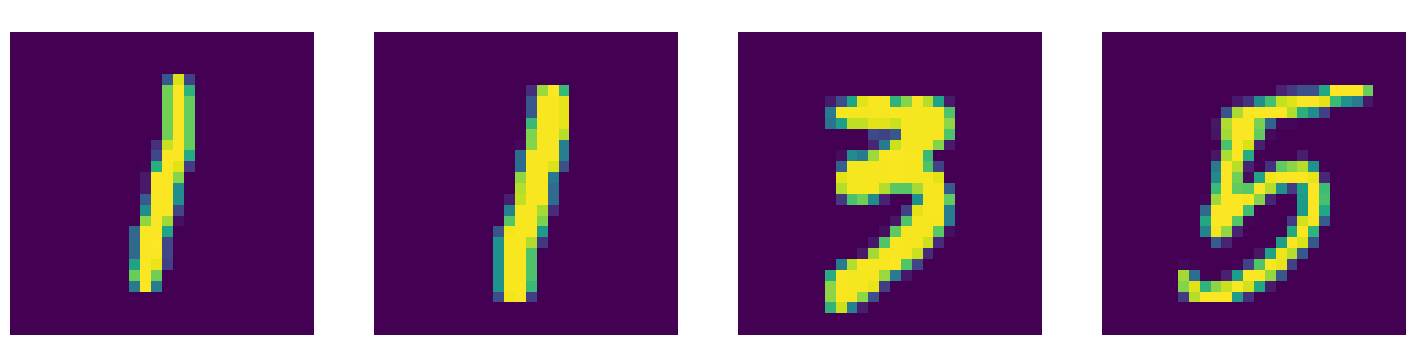

In [11]:
# Display last test batch
display_images(None, y,4, count=True)

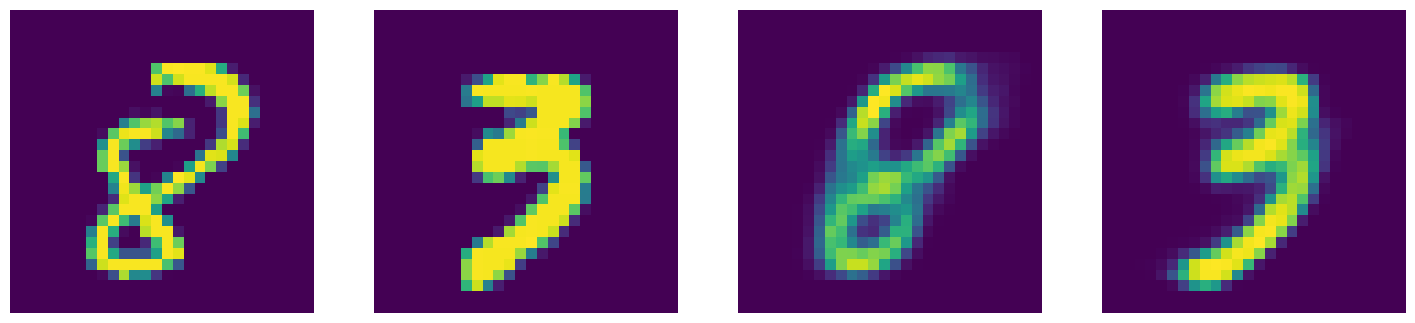

In [12]:
# Choose starting and ending point for the interpolation -> shows origin
A,B = 1,14
sample=model.decoder(torch.stack((mu[A].data,mu[B].data),0))
display_images(None, torch.stack(((
    y[A].data.view(-1),
    y[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)),0))

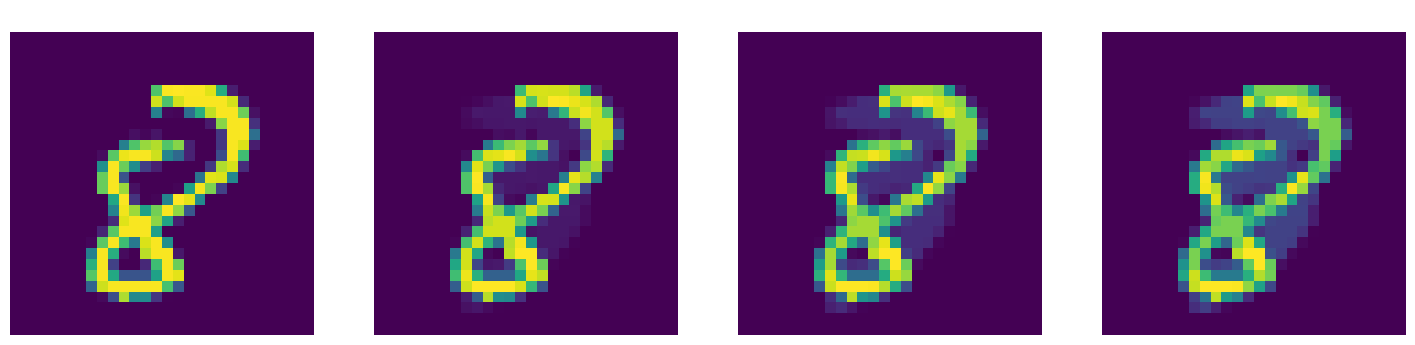

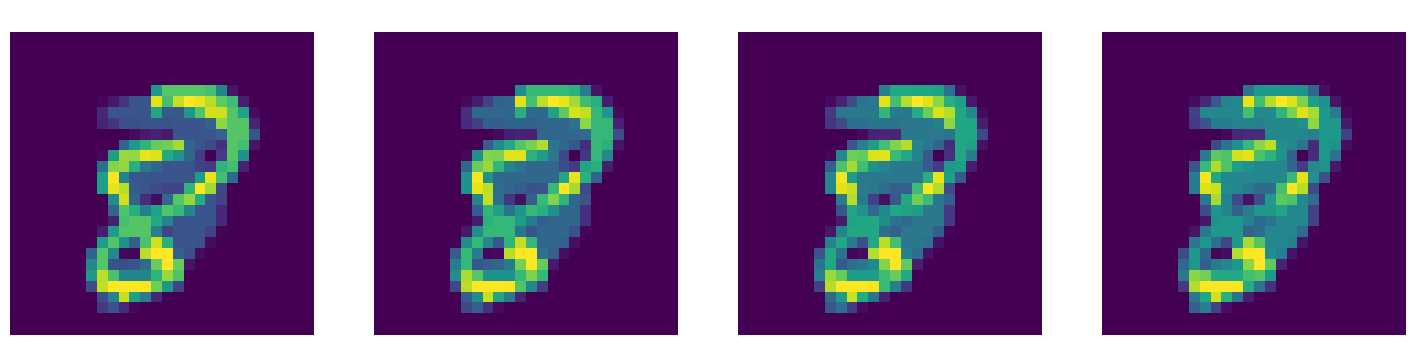

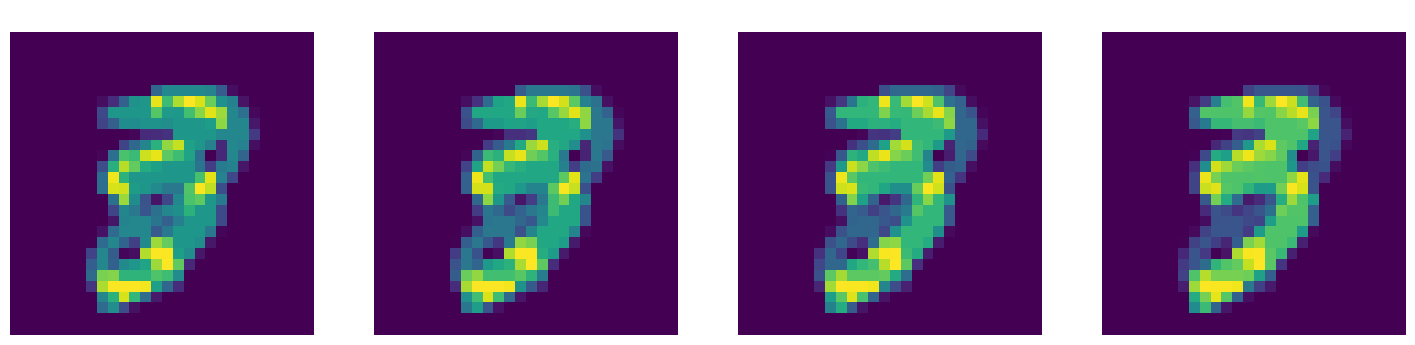

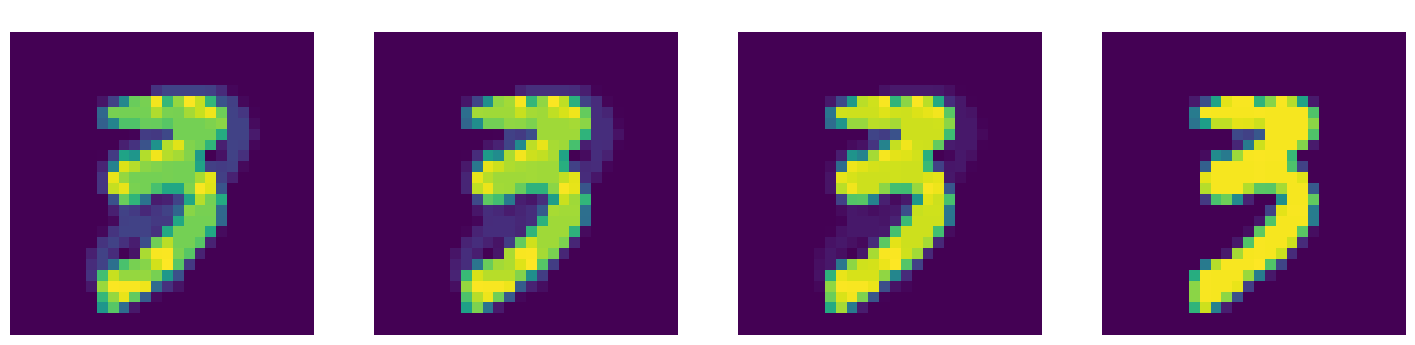

In [13]:
# Perform an interpolation between input A and B, in N steps 
N=16
code=torch.Tensor(N,20).to(device)
sample=torch.Tensor(N,28,28).to(device)
for i in range(N):
    #code[i]=i/(N-1)*mu[B].data+(1-i/(N-1))*mu[A].data
    sample[i]=i/(N-1)*y[B].data+(1-i/(N-1))*y[A].data
    #sample=model.decoder(code)
display_images(None, sample, N//4, count=True)

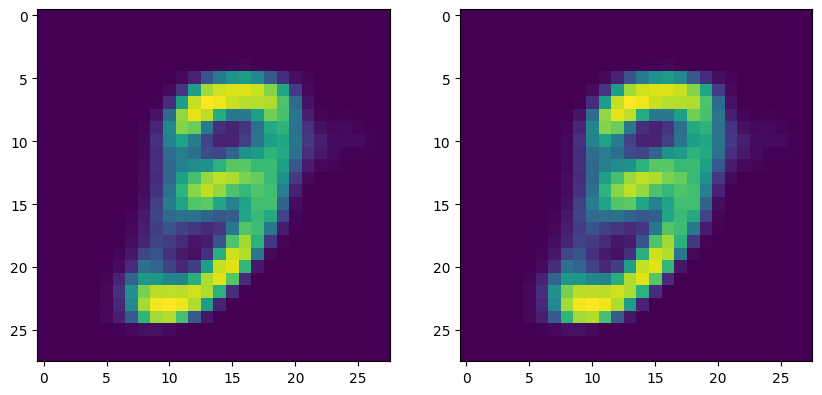

In [14]:
ybar=sample[9]
with torch.no_grad():
    ybar=model(ybar)[0]
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(ybar.view(28,28))
plt.subplot(122)
plt.imshow(ybar.view(28,28))

In [15]:
import numpy as np
from sklearn.manifold import TSNE
#from res.plot_lib import set_default

In [16]:
#set_default(figsize=(15,4))

In [18]:
X, Y, E=list(),list(),list() #input, classes, embeddings
N=2000 #samples per epoch
epochs=(0,1,2,3,4,5,10,20)
for epoch in epochs:
    Y.append(codes['mu'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(Y[-1]))
    X.append(codes['x'][epoch][:N])

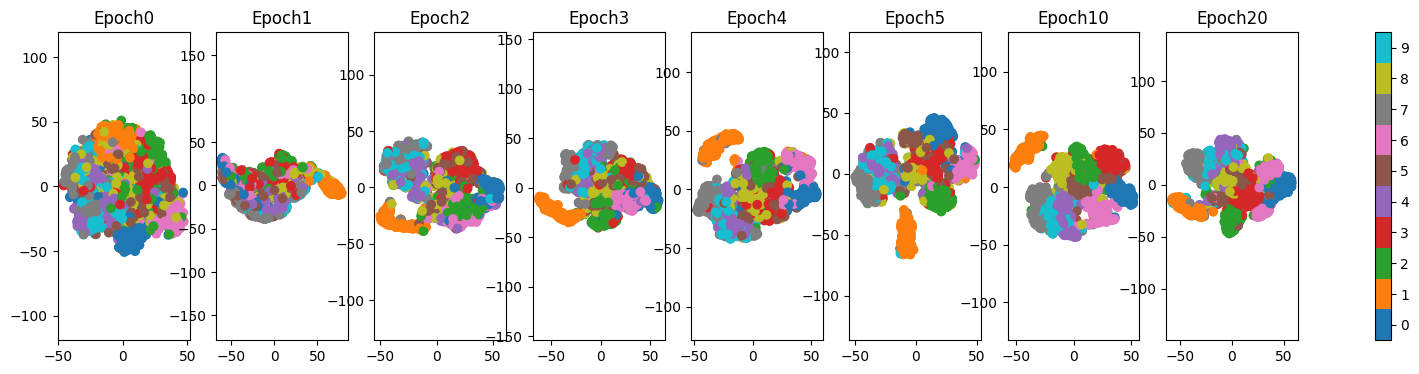

In [19]:
f,a=plt.subplots(ncols=8,figsize=(5 * 4, 4))
for i,e in enumerate(epochs):
    colors = X[i].detach().numpy().squeeze()  # Convert tensor to numpy array and remove singleton dimensions
    s=a[i].scatter(E[i][:,0],E[i][:,1],c=colors,cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch{e}')
    a[i].axis('equal')
f.colorbar(s,ax=a[:],ticks=np.arange(10),boundaries=np.arange(11)-0.5)

In [47]:
# Defining the model
d1=100
class VAEGAN1(nn.Module):
    def __init__(self,dropout_rate=0.2):
        super().__init__()
        self.dropout_rate = dropout_rate
        #self.l2_reg = l2_reg
        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, d1**2),
            #nn.BatchNorm1d(d1**2),
            nn.ReLU(),
            #nn.Dropout(p=self.dropout_rate),  # Dropout layer added
            nn.Linear(d1**2, d1*2),
            #nn.BatchNorm1d(d1*2)
        )
        #decoder
        self.decoder = nn.Sequential(
            nn.Linear(d1,d1**2),
            #nn.BatchNorm1d(d1**2),
            nn.ReLU(),
            #nn.Dropout(p=self.dropout_rate),
            nn.Linear(d1**2, 784),
            nn.Sigmoid()
        )
        # Discriminator
        self.discriminator = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            #nn.Dropout(p=self.dropout_rate),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def reparameterise(self, mu, logvar):
        if self.training:
            std=logvar.mul(0.5).exp_()
            eps=std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    def forward(self,y):
        mu_logvar=self.encoder(y.view(-1,784)).view(-1,2,d1)
        mu=mu_logvar[:,0,:]
        logvar=mu_logvar[:,1,:]
        z=self.reparameterise(mu, logvar)
        return self.decoder(z),mu,logvar
    def discriminate(self, x):
        return self.discriminator(x.view(-1, 784))
model1 = VAEGAN1().to(device)

In [48]:
# Setting the optimiser
learning_rate=1e-3
optimizer1=torch.optim.Adam(
    model1.parameters(),
    lr=learning_rate,
    #weight_decay=1e-3
)
discriminator_optimizer1 = torch.optim.Adam(model1.discriminator.parameters(), lr=learning_rate)

====> Epoch: 0 Average loss: 504616.18333333335
====> Test set loss:  367.0943
====> Epoch: 1 Average loss: 402239.553125
====> Test set loss:  347.0229
====> Epoch: 2 Average loss: 379431.6458333333
====> Test set loss:  247.7857
====> Epoch: 3 Average loss: 349705.42604166665
====> Test set loss:  207.1779
====> Epoch: 4 Average loss: 328458.85520833335
====> Test set loss:  186.8587
====> Epoch: 5 Average loss: 314208.3697916667
====> Test set loss:  178.0751
====> Epoch: 6 Average loss: 303869.925
====> Test set loss:  168.4420
====> Epoch: 7 Average loss: 296035.18333333335
====> Test set loss:  162.5893
====> Epoch: 8 Average loss: 290033.70625
====> Test set loss:  155.9546
====> Epoch: 9 Average loss: 284849.74375
====> Test set loss:  150.0192
====> Epoch: 10 Average loss: 280185.8104166667
====> Test set loss:  146.4455


C:\Users\SRUTHI\AppData\Local\Temp\ipykernel_13888\613348245.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18,4))


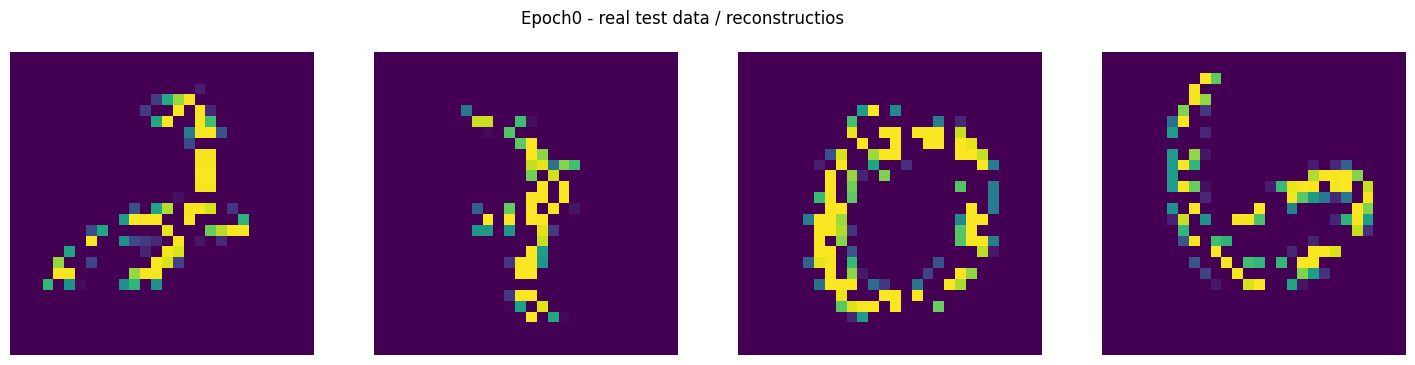

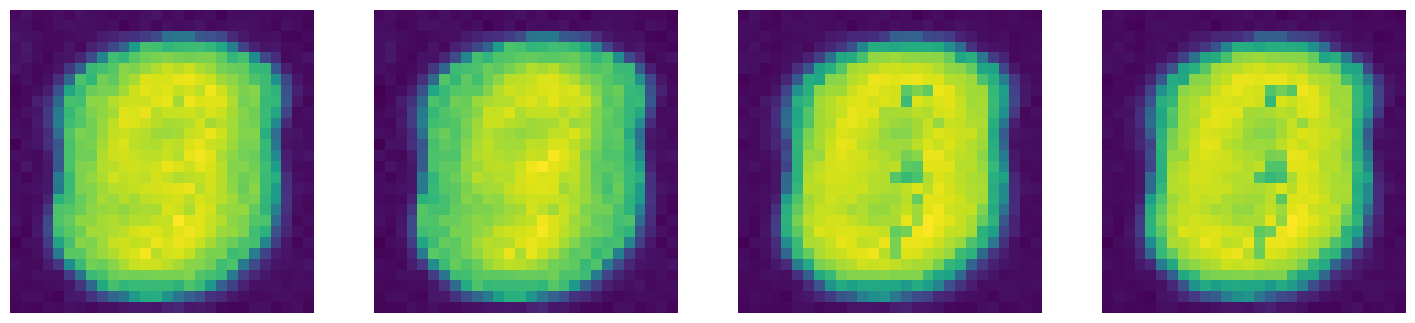

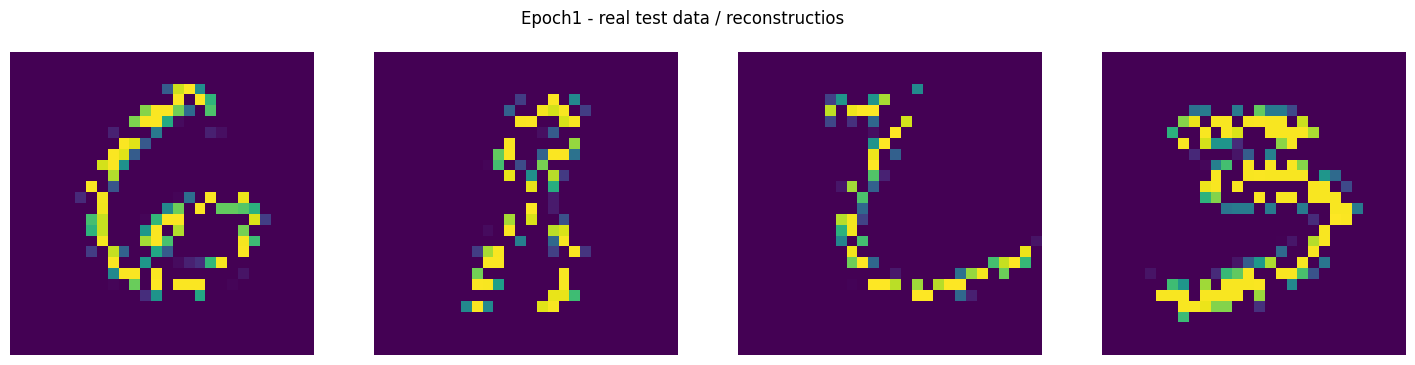

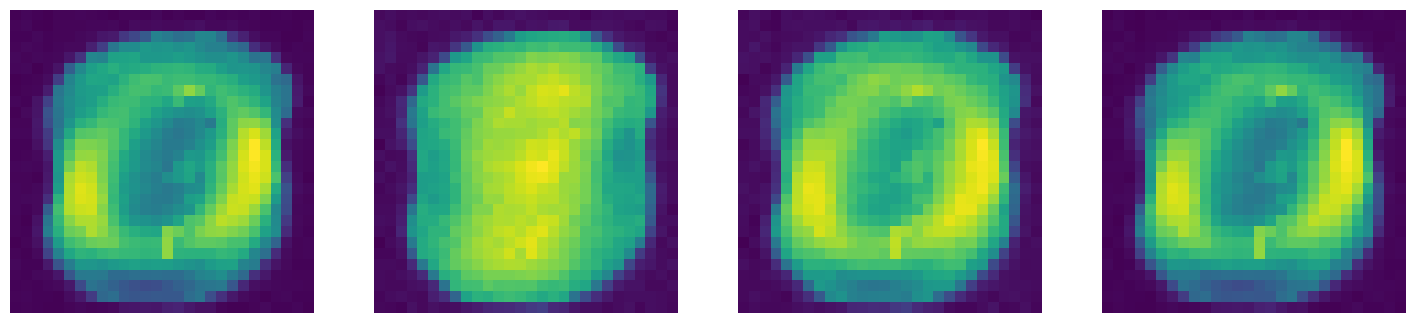

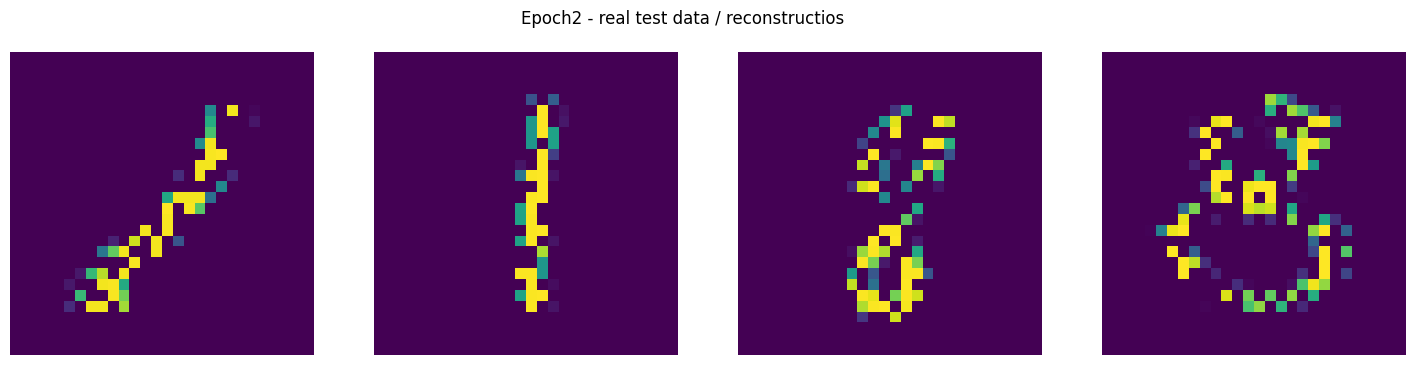

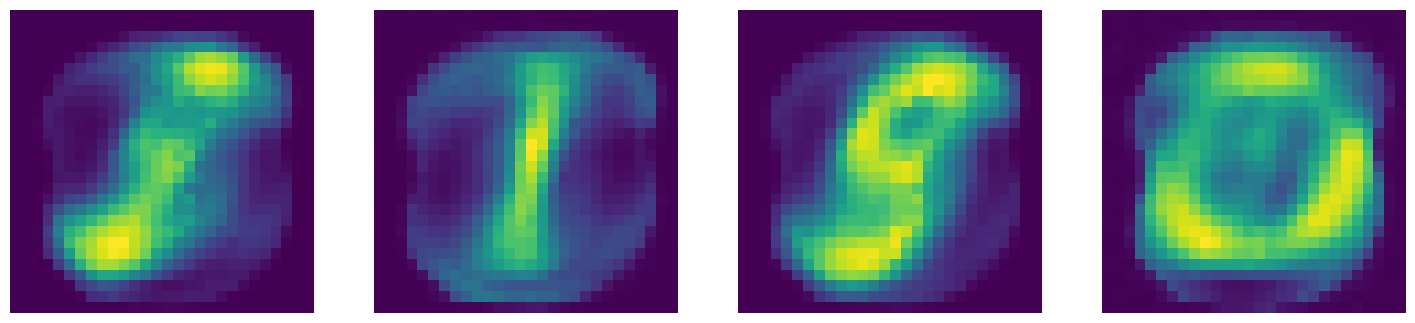

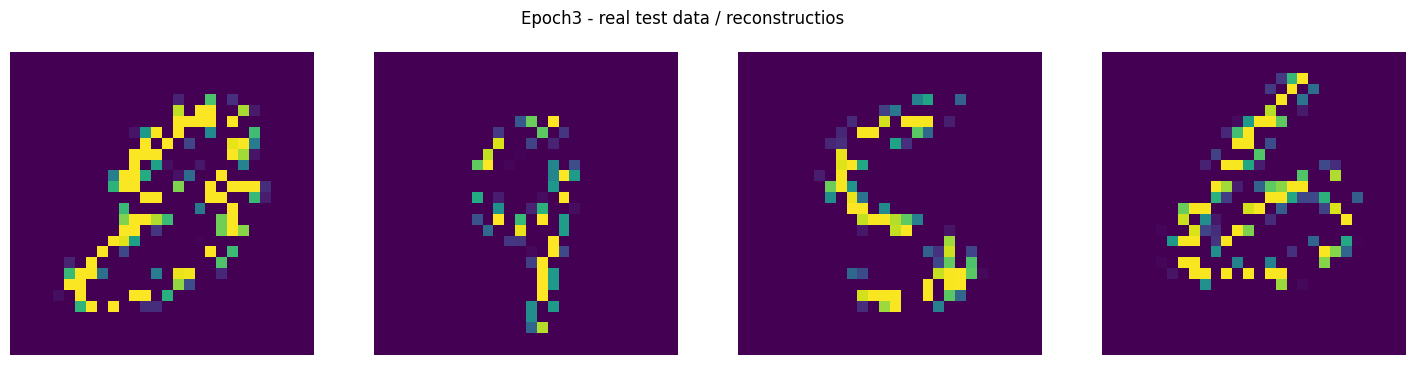

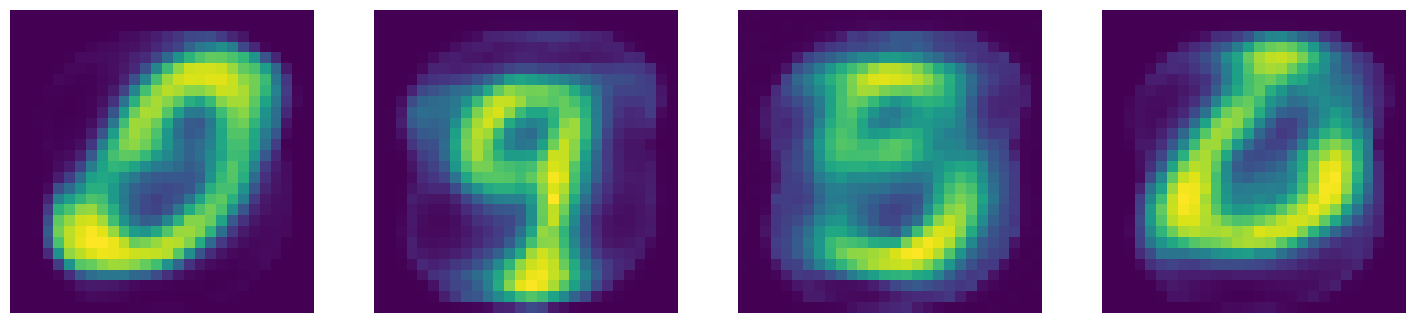

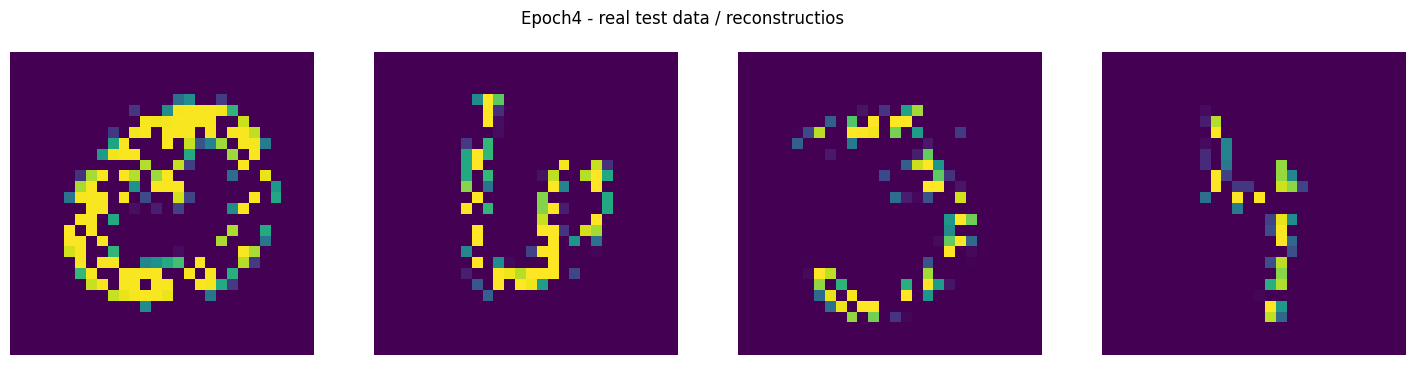

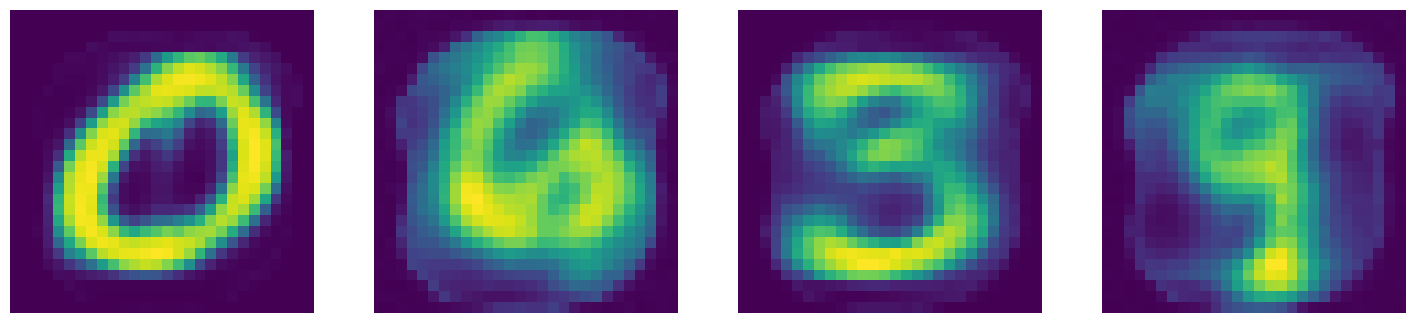

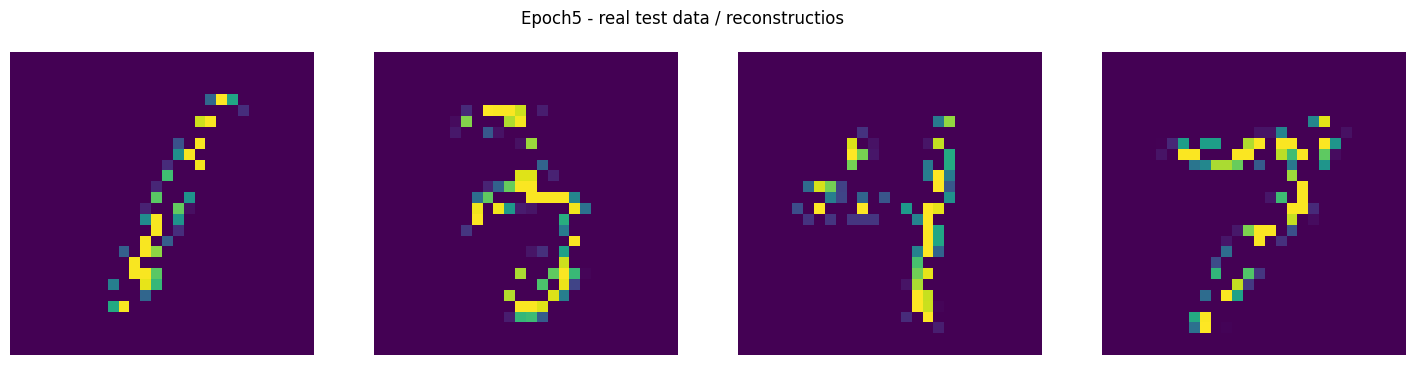

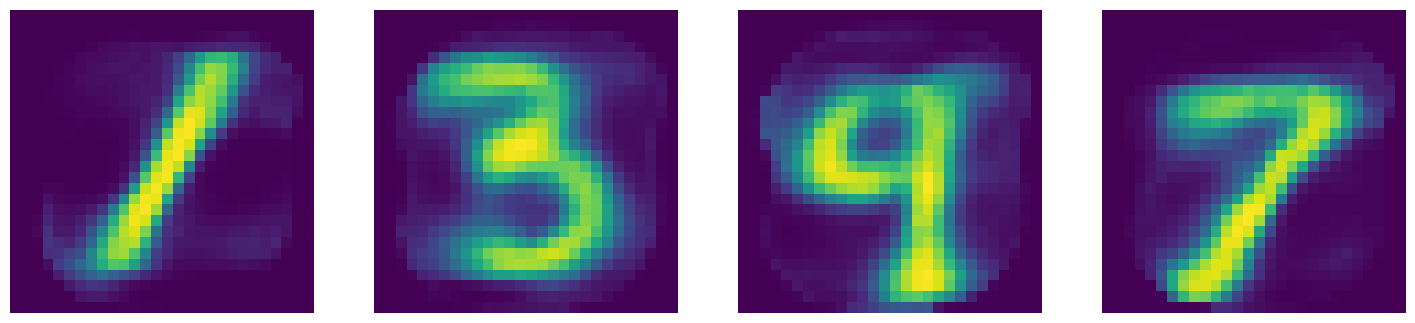

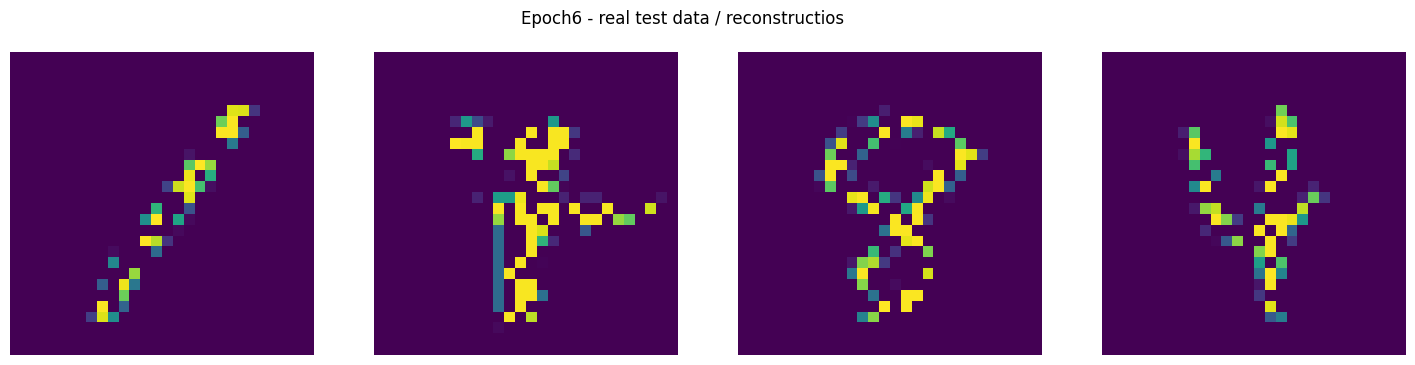

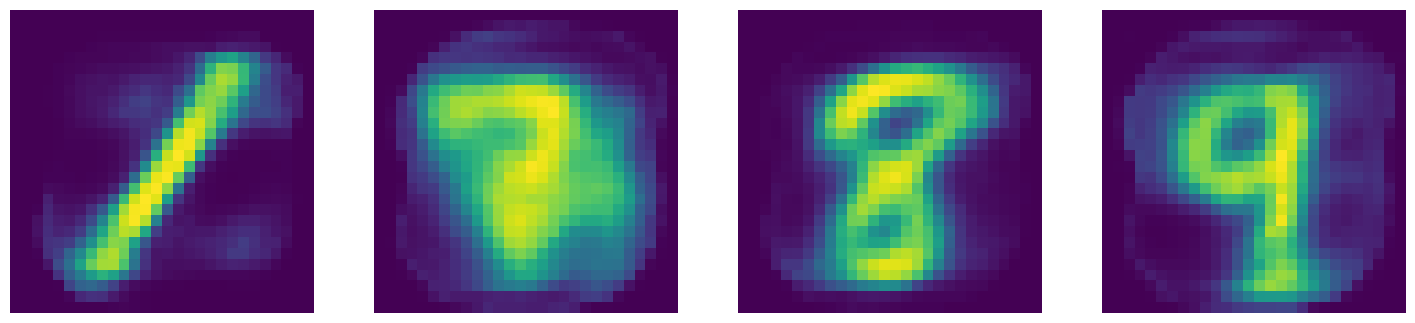

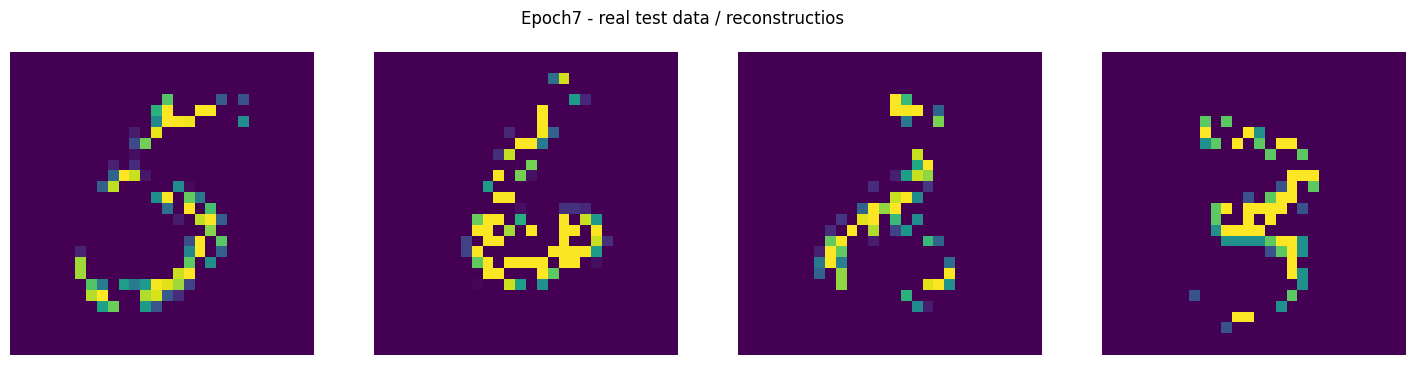

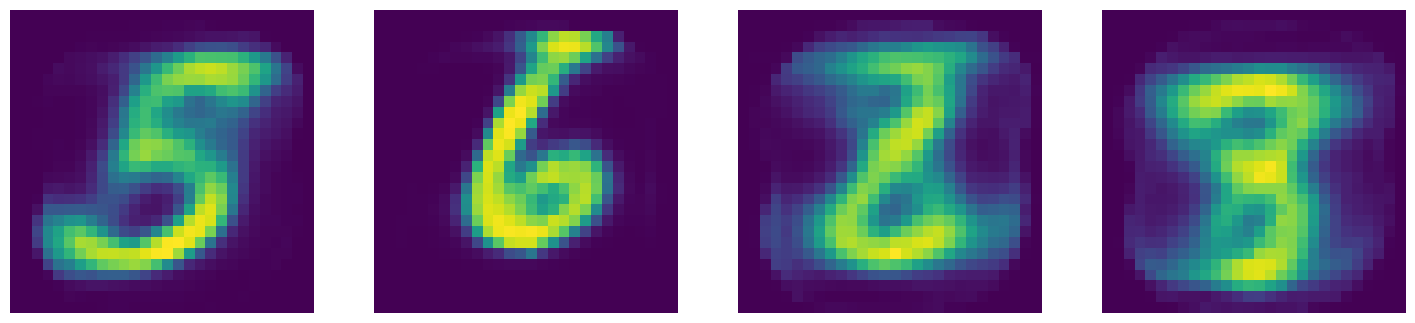

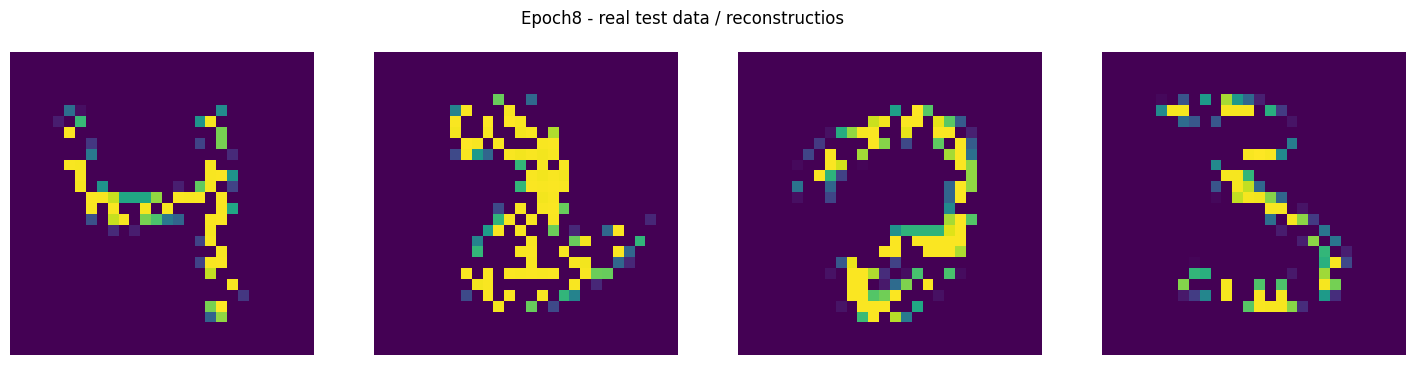

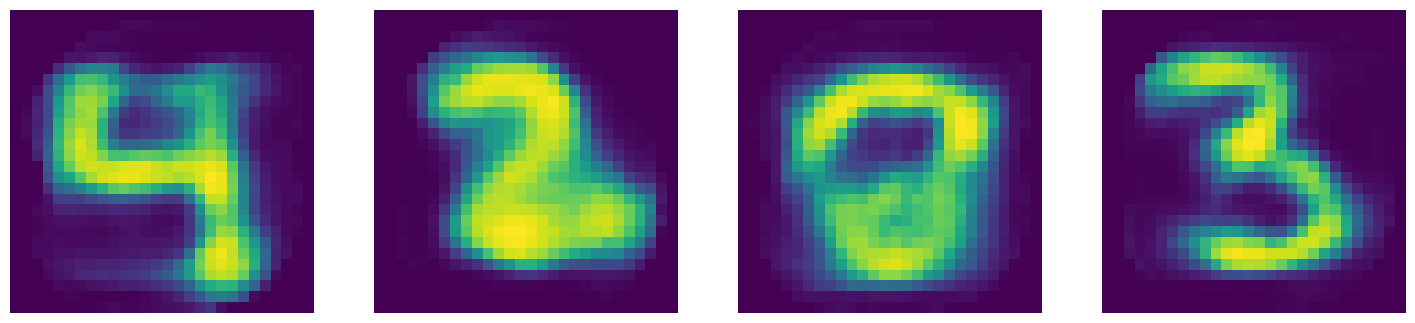

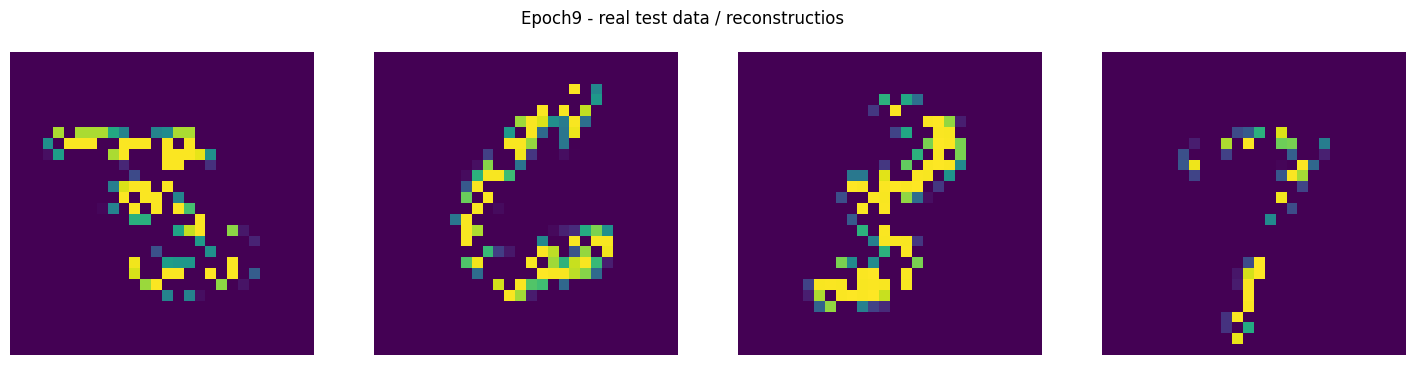

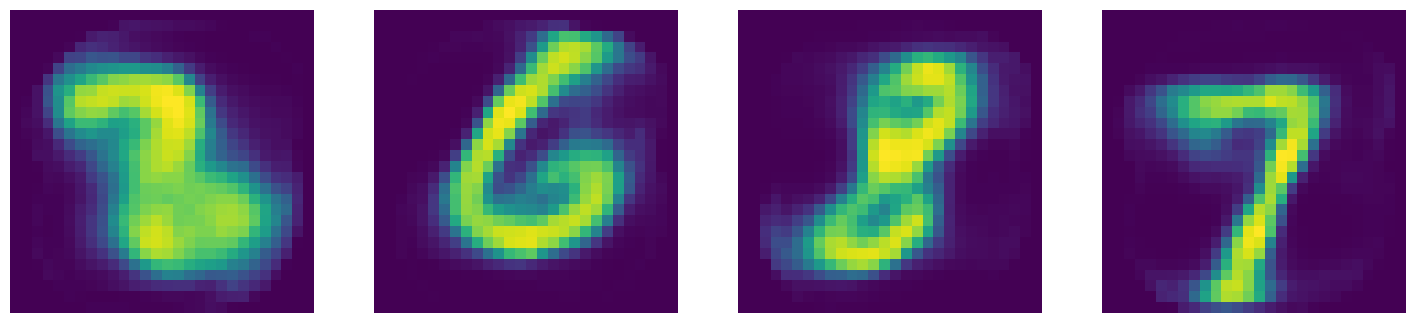

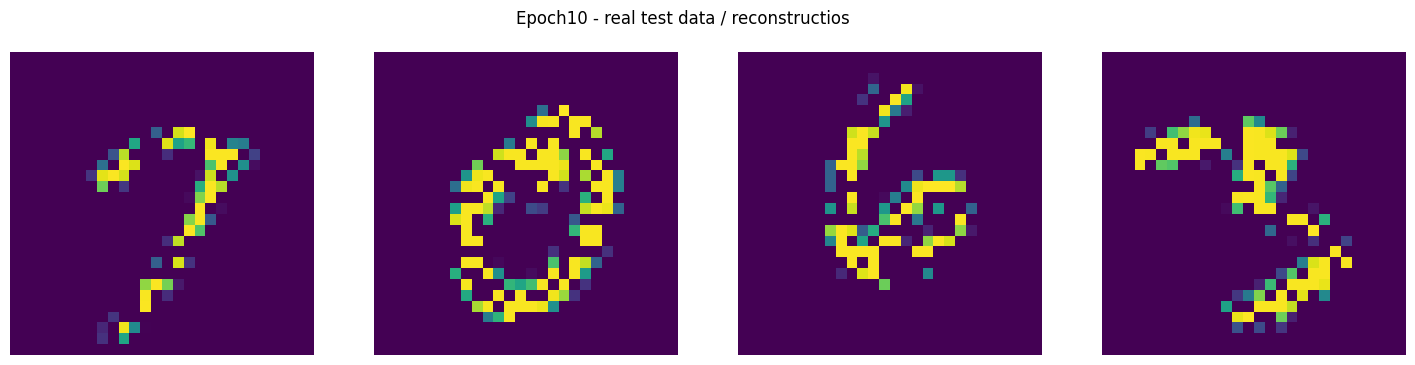

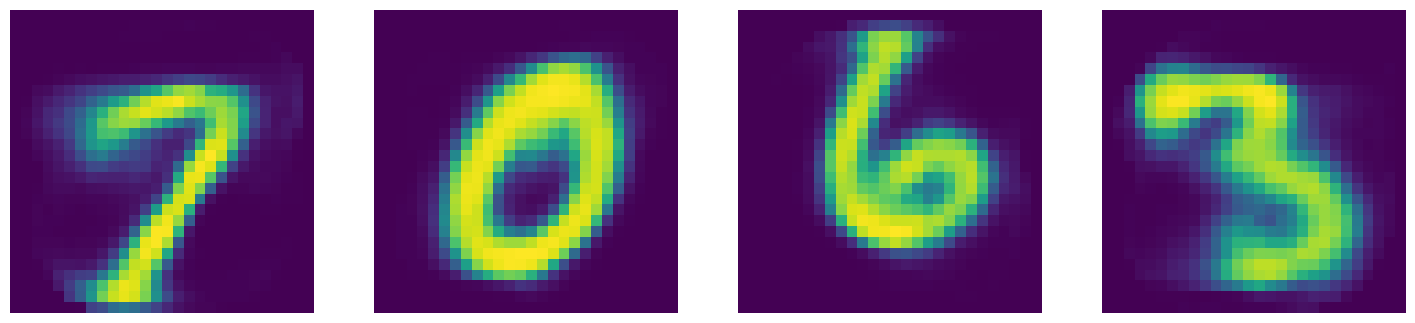

In [49]:
# Training and testing the VAEGAN
epochs = 10
codes = dict(mu=list(), logsigmabase2=list(), x=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > -1:  # test untrained net first
        model1.train()
        train_loss = 0
        for y, _ in train_loader:
            y = y.to(device)
            noise = do(torch.ones(y.shape)).to(device) #included
            img_bad = do(y * noise).to(device) #included
            # ============forward===============================
            ybar, mu, logvar = model1(img_bad)
            loss = loss_function(ybar, y, mu, logvar)
            discriminator_loss = discriminator_criterion(model1.discriminate(ybar), torch.ones(y.size(0), 1).to(device))
            loss+=discriminator_loss
            train_loss += loss.item()
            # ============backward===============================
            optimizer1.zero_grad()
            discriminator_optimizer1.zero_grad()
            loss.backward()
            optimizer1.step()
            discriminator_optimizer1.step()
        # ===============log=====================================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader)}')
    # Testing
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model1.eval()
        test_loss = 0
        for y, x in test_loader:
            y = y.to(device)
            y= y.view(y.size(0),-1)
            noise = do(torch.ones(y.shape)).to(device)
            img_bad = (y * noise).to(device)
            # ================forward===================================
            ybar, mu, logvar = model1(y)
            test_loss += loss_function(ybar, y, mu, logvar).item()
            # =================log======================================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(x.detach())
    # =================log======================================
    codes['mu'].append(torch.cat(means))
    codes['logsigmabase2'].append(torch.cat(logvars))
    codes['x'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss: .4f}')
    display_images(img_bad, ybar, 1, f'Epoch{epoch}')